# Reproduction notebook for the paper "Radio monitoring of transient Be/X-ray binaries and the inflow-outflow coupling of strongly-magnetized accreting neutron stars" by J van den Eijnden et al. (2022)

Table of contents for this notebook:
#### Note that this notebook is meant to be executed in order. All steps execute reasonaly quickly, with the exception of plotting Figure 3 and the MCMC runs. For those MCMC runs, we provide the option to read in output from an earlier run (either performed by us, or your own earlier run if you performed this step before), to speed up the plotting process.

- Step 0: Loading python packages and basic plotting settings
- Step 1: Plotting NICER spectra and residuals of 1A 0535+252 (Figure 1)
- Step 2: Plotting the X-ray and radio light curves of all three targets (Figure 2, 4, 5)
- Step 3: Plotting the discovery image of the radio counterpart of 1A 0535+262 (Figure 3)
- Step 4: Plotting the X-ray / radio luminosity diagram (Figure 6 and 7)
- Step 5: Performing the MCMC linmix fit to all BeXRB giant outburst points (Figure 8 and B1)
- Step 6: Repeating Step 5 for the two BeXRBs with detections individually
- Step 7: Plotting the radio spectra of 1A 0535+262 for the Online Supplementary Materials
- Step 8: Plotting the Swift and NICER parameter light curves for the Online Supplementary Materials
- Step 9: Plotting the NICER response comparison for the Online Supplementary Materials

## Step 0: loading python packages and basic plotting settings

This code uses the following python packages and versions:

numpy v1.15.4

matplotlib v2.2.3

aplpy v1.1.1

scipy v1.1.0

astropy v2.0.9

linmix v0.1.0.dev1, obtained from https://github.com/jmeyers314/linmix_py. An installation guide and tutorial on the use of linmix is available on https://linmix.readthedocs.io/en/latest/

### Setting the path for the font to use in plotting labels and texts:

In [1]:
# Make sure to change this path to your local version, or otherwise comment out the noted line in the next cell
path = '/Library/Fonts/Arial Unicode.ttf'

### Loading the packages and setting up plots

In [2]:
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.patches import ConnectionPatch
import aplpy

from scipy import interpolate
from scipy import optimize
from scipy.integrate import quad
import scipy.special
import scipy.stats as ST

import os
from astropy import units as u
from astropy.units import cds
cds.enable()  

import linmix

from IPython.display import display, clear_output

# If the font should not be changed, comment out the next two lines:
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['pdf.fonttype']=42

params = {'text.usetex':False, 'mathtext.fontset':'custom', 'mathtext.default':'regular'}
mpl.rcParams.update(params)

single_col = 8.9 # cm
double_col = 18.3 # cm
def cm2inch(value):
    return value/2.54
FS = 18
LS = 18
MS = 10
MEW= 1.5

%matplotlib inline

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## Step 1: Plotting NICER spectra and residuals of 1A 0535+252 (Figure 1)

In [3]:
# Reading in the xspec output files: 
# the number refers to the ObsID of the NICER observation. QDP files are generated by plotting in xspec
# using the iplot command, and the using wdata to write out all plotted data in the figure.

o135_ufspec = np.genfromtxt('./Figure1/3200360135_ufspec.qdp', unpack=True)
o135_chi = np.genfromtxt('./Figure1/3200360135_chi.qdp', unpack=True)

o140_ufspec = np.genfromtxt('./Figure1/3200360140_ufspec.qdp', unpack=True)
o140_chi = np.genfromtxt('./Figure1/3200360140_chi.qdp', unpack=True)

o145_ufspec = np.genfromtxt('./Figure1/3200360145_ufspec.qdp', unpack=True)
o145_chi = np.genfromtxt('./Figure1/3200360145_chi.qdp', unpack=True)

o150_ufspec = np.genfromtxt('./Figure1/3200360150_ufspec.qdp', unpack=True)
o150_chi = np.genfromtxt('./Figure1/3200360150_chi.qdp', unpack=True)

o155_ufspec = np.genfromtxt('./Figure1/3200360155_ufspec.qdp', unpack=True)
o155_chi = np.genfromtxt('./Figure1/3200360155_chi.qdp', unpack=True)

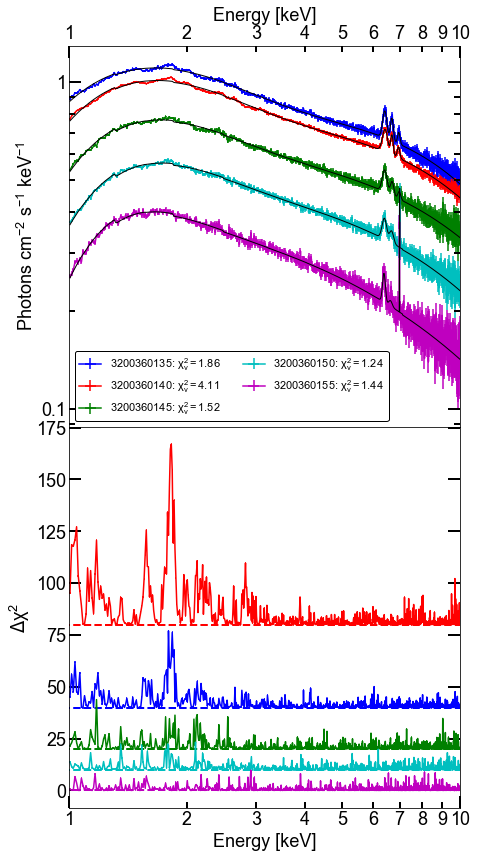

In [4]:
# Plotting the figure with two panels:
fig = plt.figure(figsize=(cm2inch(2.*single_col),cm2inch(4.*single_col)))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Basic plotting setup:
for ax in [ax1,ax2]:
    ax.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=3)
    ax.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=3)

    ax.yaxis.set_ticks_position('both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    
    ax.set_xscale('log')
    ax.set_xlim(1, 10)
    
ax1.set_yscale('log')

# Plotting the x-axis labels and ticks at the top for the top panel:
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')

# Defining x-axis and y-axis labels:
ax1.set_xlabel('Energy [keV]', fontsize=FS)
ax2.set_xlabel('Energy [keV]', fontsize=FS)

ax1.set_ylabel(r'Photons cm$^{-2}$ s$^{-1}$ keV$^{-1}$', fontsize=LS)
ax2.set_ylabel(r'$\Delta \chi^2$', fontsize=LS)

# Defining the colors and labels for the ObsIDs to loop over when plotting:
colors = ['b', 'r', 'g', 'c', 'm']
specs = [o135_ufspec,o140_ufspec,o145_ufspec,o150_ufspec,o155_ufspec]
labels = [r'3200360135: $\chi^2_\nu = 1.86$',
          r'3200360140: $\chi^2_\nu = 4.11$',
          r'3200360145: $\chi^2_\nu = 1.52$',
          r'3200360150: $\chi^2_\nu = 1.24$',
          r'3200360155: $\chi^2_\nu = 1.44$']

# Plotting the top panel:
i=0
for spec in specs:
    ax1.errorbar(spec[0], spec[2], xerr=spec[1], yerr=spec[3], zorder=1, color=colors[i], label=labels[i])
    ax1.plot(spec[0], spec[4], 'k-', lw=1, zorder=2)
    i += 1

# Adding a legend with a frame:
legend = ax1.legend(loc=3, fontsize=FS-7, ncol=2, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

# plotting the data in the bottom panel: the vertical offsets are determined by eye:
ax2.errorbar(o135_chi[0], abs(o135_chi[2])+40, xerr=o135_chi[1], color=colors[0])
ax2.errorbar(o140_chi[0], abs(o140_chi[2])+80, xerr=o140_chi[1], color=colors[1])
ax2.errorbar(o145_chi[0], abs(o145_chi[2])+20, xerr=o145_chi[1], color=colors[2])
ax2.errorbar(o150_chi[0], abs(o150_chi[2])+10, xerr=o150_chi[1], color=colors[3])
ax2.errorbar(o155_chi[0], abs(o155_chi[2]), xerr=o155_chi[1], color=colors[4])

# Plotting the offset zero line for each ObsID in the bottom panel.
ax2.plot([0,100], [40,40], '--', color=colors[0], lw=2)
ax2.plot([0,100], [80,80], '--', color=colors[1], lw=2)
ax2.plot([0,100], [20,20], '--', color=colors[2], lw=2)
ax2.plot([0,100], [10,10], '--', color=colors[3], lw=2)
ax2.plot([0,100], [0,0], '--', color=colors[4], lw=2)

# Defining the xticks and yticks for all axes, as matplotlib sometimes uses ugly notation on log axes:
for ax in [ax1,ax2]:
    ax.set_xticks([2,3,4,5,6,7,8,9], minor=True)
    ax.set_xticks([1,10], minor=False)
    ax.set_xticklabels(['2','3','4','5','6','7','8','9'], minor=True)
    ax.set_xticklabels(['1','10'], minor=False)
    
ax1.set_yticks([0.1, 1], minor=False)
ax1.set_yticklabels(['0.1', '1'], minor=False)

# Removing the vertical space between the panels and saving:
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./Figure1/Figure1.png', dpi=500)

## Step 2: Plotting the X-ray and radio light curves of all three targets (Figure 2, 4, 5)

### 1A 0535+262 / Figure 2

In [5]:
# Read in the VLA data:

VLA_t, VLA_F, VLA_dF, VLA_UL = np.genfromtxt('./Figure2/a0535.radio_results.txt', usecols=[0,1,2,3], unpack=True)

In [6]:
# Read in the BAT data and convert to Crab units:

BAT_Crab = 0.220

time, rate, error = np.genfromtxt('./Figure2/a0535_BAT_complete_daily.txt', usecols=[0,1,2], unpack=True)

rate_Crab = rate/BAT_Crab
error_Crab = error/BAT_Crab

In [12]:
# Read in the Swift and NICER fluxes from pointed observations:

MJD_NICER, flux_05_10keV, dflux_05_10keV = np.genfromtxt('./Figure2/a0535_NICER_lc.txt', usecols=[0,1,2], unpack=True)
MJD_Swift, SWflux_05_10keV, dSWflux_05_10keV = np.genfromtxt('./Figure2/a0535_SWIFT_lc.txt', usecols=[0,1,2], unpack=True)

# Manually remove the Swift points on MJD 59226 and 59281: those are very short exposures, so, as noted in the
# paper, we don't include them in the plot. 
for i in xrange(len(MJD_Swift)):
    if MJD_Swift[i] in [59226.6493822, 59281.3484954]:
        SWflux_05_10keV[i] = 1e-100

In [13]:
# Defining the long-term time axis labels:

MJDyears = [53371, 53736, 54101, 54466, 54832, 55197, 55562, 55927, 56293, 56658, 57023, 57388, 57754, 58119, 58484, 58849, 59215]
Labelsyears = ['2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015',
               '2016','2017','2018','2019','2020','2021',]

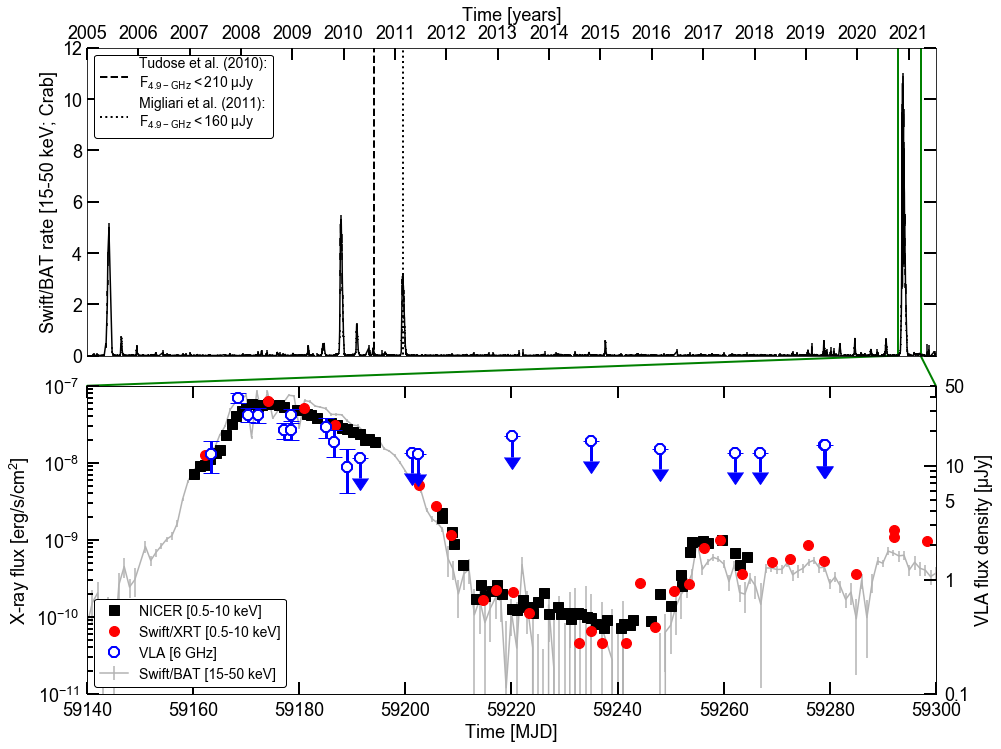

In [16]:
# Making the actual figure

fig = plt.figure(figsize=(cm2inch(4.*single_col),cm2inch(3.*single_col)))

########## TOP PANEL ##########
ax = fig.add_subplot(211)

## Setup of the basic figure: note the 211 since there will be a bottom row.
ax.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.set_xlim(53371,59409)
ax.set_ylim(0, 12)
ax.set_xticks(MJDyears)
ax.set_xticklabels(Labelsyears)
 
## Plotting the Swift BAT light curve in the top panel:
ax.errorbar(time, rate_Crab, yerr=error_Crab, fmt='s-', color='k', ms=0)

## Plotting the range for the zoom in the bottom panel:
ax.plot([59140,59140], [-1,100], 'g-', lw=2)
ax.plot([59300,59300], [-1,100], 'g-', lw=2)

## Indicating the times of previous radio observations:
ax.plot([55410,55410], [-1,100], 'k--', lw=2, label=r'Tudose et al. (2010):'+'\n'+r'$F_{4.9-\rm GHz} < 210$ $\mu$Jy')    
ax.plot([55615,55615], [-1,100], 'k:', lw=2, label=r'Migliari et al. (2011):'+'\n'+r'$F_{4.9-\rm GHz} < 160$ $\mu$Jy')    

# Labeling the axes:
ax.set_xlabel('Time [years]', fontsize=FS)
ax.set_ylabel('Swift/BAT rate [15-50 keV; Crab]', fontsize=FS)

# Including a legend:
legend = ax.legend(loc=2, fontsize=FS-4, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

########## BOTTOM PANEL ##########

## Creating the axis and twinning it to plot both radio and X-ray data:
ax1 = fig.add_subplot(212)
ax2 = ax1.twinx()

## Basic setup of the axis properties, shared by radio and X-ray axes:
for ax_i in [ax1,ax2]:
    ax_i.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=8)
    ax_i.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=8)

    ax_i.xaxis.set_ticks_position('both')
    ax_i.get_yaxis().set_tick_params(direction='in', which='both')
    ax_i.get_xaxis().set_tick_params(direction='in', which='both')

    ax_i.set_xlim(59140,59300)

## Plotting the X-ray light curves from BAT (re-scaled), NICER, and Swift:
ax1.errorbar(time, (8e-9)*rate_Crab, yerr=(8e-9)*error_Crab, fmt='s-', color='0.7', ms=0, label='Swift/BAT [15-50 keV]', zorder=0) #0.7
ax1.plot(MJD_NICER, flux_05_10keV, 'ks', ms=10, label='NICER [0.5-10 keV]')
ax1.plot(MJD_Swift, SWflux_05_10keV, 'ro', ms=10, label='Swift/XRT [0.5-10 keV]')

## Adding some X-ray specific axis setup:
ax1.set_ylim(1e-11, 1e-7)
ax1.set_yscale('log')
ax1.set_ylabel(r'X-ray flux [erg/s/cm$^2$]', fontsize=FS)
ax1.set_xlabel('Time [MJD]', fontsize=FS)

## Defining the label of the radio data (in the twinned axis) so that X-rays and radio share one legend:
ax1.plot([], [], 'w8', ms=10, mec='b', mew=2, label='VLA [6 GHz]')

## Including a legend
legend = ax1.legend(loc=3, fontsize=FS-4, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

## Plotting the radio light curve in the twinned axis: two commands to allow for white markers with visible errorbars:
ax2.errorbar(VLA_t, VLA_F, VLA_dF, fmt='b8', ms=0, elinewidth=3, uplims=VLA_UL, capsize=8)
ax2.plot(VLA_t, VLA_F, 'w8', ms=10, mec='b', mew=2)

## Adding some radio specific axis setup:
ax2.set_yscale('log')
ax2.set_ylim(0.1, 50)
ax2.set_ylabel(r'VLA flux density [$\mu$Jy]', fontsize=FS, color='k')

ax2.set_yticks([2,3,4,5,6,7,8,9,20,30,40,50], minor=True)
ax2.set_yticks([0.1,1,10], minor=False)
ax2.set_yticklabels([0.1, 1, 10], minor=False)
ax2.set_yticklabels(['','','',5,'','','','','','','',50], minor=True)

########## CONNECTING THE PANELS ##########

## Adding lines connecting the range in the top panel with the edges of the bottom panel:
con1 = ConnectionPatch(xyA=(59140,0.), xyB=(59140,1e-7), coordsA="data", coordsB="data", axesA=ax, axesB=ax1, color="g", lw=2)
con2 = ConnectionPatch(xyA=(59300,0.), xyB=(59300,1e-7), coordsA="data", coordsB="data", axesA=ax, axesB=ax1, color="g", lw=2)
ax.add_artist(con1)
ax.add_artist(con2)

## Saving the figure:
plt.tight_layout()
plt.savefig('./Figure2/Figure2.png', dpi=500)

### SAX J2103.5+4545 / Figure 4

In [17]:
# Reading in the BAT data:

time, rate, error = np.genfromtxt('Figure4/saxJ2103.bat.daily', usecols=[0,1,2], unpack=True)

rate_Crab = rate/BAT_Crab
error_Crab = error/BAT_Crab

In [18]:
# Reading in the Swift data and converting from logarithmic units:

swift_date, swift_flux, swift_dflux_m, swift_dflux_p = np.genfromtxt('Figure4/saxj2103.swift.txt', usecols=[0,1,2,3], unpack=True)

swift_dflux = ((10**swift_flux - 10**(swift_flux + swift_dflux_m)) + (10**(swift_flux + swift_dflux_p) - 10**swift_flux)) /2.
swift_flux = 10**swift_flux

In [19]:
# Reading in the VLA radio data:

VLA_t, VLA_F, VLA_dF = np.genfromtxt('Figure4/saxJ2103.radio_results.txt', usecols=[0,1,2], unpack=True)

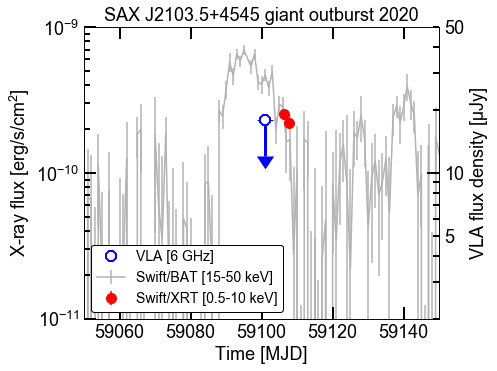

In [20]:
# Making the actual figure:
# The below code uses the same style as the bottom panel of Figure 1.
# We refer to that code for comments and explanation.

fig = plt.figure(figsize=(cm2inch(2*single_col),cm2inch(1.5*single_col)))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

for ax in [ax1,ax2]:
    ax.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=5)
    ax.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=5)

    ax.xaxis.set_ticks_position('both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(direction='in', which='both')

    ax.set_xlim(59050,59150)

##########    
    
ax1.errorbar(time, 8e-9*rate_Crab, yerr=8e-9*error_Crab, fmt='s-', color='0.7', ms=0, label='Swift/BAT [15-50 keV]', zorder=0) #0.7
ax1.errorbar(swift_date, swift_flux, yerr=swift_dflux, fmt='ro', ms=10, label='Swift/XRT [0.5-10 keV]')

ax1.set_ylim(1e-11, 1e-9)
ax1.set_yscale('log')
ax1.set_ylabel('X-ray flux [erg/s/cm$^2$]', fontsize=FS)
ax1.set_xlabel('Time [MJD]', fontsize=FS)

ax1.set_title('SAX J2103.5+4545 giant outburst 2020', fontsize=FS)
ax1.plot([], [], 'w8', ms=10, mec='b', mew=2, label='VLA [6 GHz]')

##########

ax2.errorbar(VLA_t, VLA_F, VLA_dF, fmt='b8', ms=0, elinewidth=3, uplims=True, capsize=8)
ax2.plot(VLA_t, VLA_F, 'w8', ms=10, mec='b', mew=2)

ax2.set_yscale('log')
ax2.set_ylim(2, 50)
ax2.set_ylabel(r'VLA flux density [$\mu$Jy]', fontsize=FS, color='k')

ax2.set_yticks([2,3,4,5,6,7,8,9,20,30,40,50], minor=True)
ax2.set_yticks([10], minor=False)
ax2.set_yticklabels([10], minor=False)
ax2.set_yticklabels(['','','',5,'','','','','','','',50], minor=True)

legend = ax1.legend(loc=3, fontsize=FS-4, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

plt.tight_layout()
plt.savefig('./Figure4/Figure4.png', dpi=500)

### GRO J1008-57 / Figure 5

In [21]:
# Reading in the BAT data:

time, rate, error = np.genfromtxt('./Figure5/j1008_BAT_complete_daily.txt', usecols=[0,1,2], unpack=True)

rate_Crab = rate/BAT_Crab
error_Crab = error/BAT_Crab

In [22]:
# Reading in the ATCA data for the giant and periastron outburst.
# Flow = 5.5 GHz
# Fhigh = 9 GHz
ATCA_giant_t, ATCA_giant_Flow, ATCA_giant_dFlow, ATCA_giant_Fhigh, ATCA_giant_dFhigh = np.genfromtxt('./Figure5/j1008.giant.radio_results.txt', usecols=[0,1,2,3,4], unpack=True)
ATCA_periastron_t, ATCA_periastron_Flow, ATCA_periastron_dFlow, ATCA_periastron_Fhigh, ATCA_periastron_dFhigh = np.genfromtxt('./Figure5/j1008.periastron.radio_results.txt', usecols=[0,1,2,3,4], unpack=True)

In [23]:
# Reading in the periastron outburst Swift data:
swift_date, swift_flux, swift_dflux = np.genfromtxt('./Figure5/j1008.periastron.swift.txt', usecols=[1,2,3], unpack=True)

In [24]:
# Reading in the giant outburst MAXI data:
maxi_date, maxi_ddate = np.genfromtxt('./Figure5/j1008.giant.maxi.dates.txt', unpack=True)
maxi_min, maxi_max = np.genfromtxt('./Figure5/j1008.giant.maxi.txt', unpack=True, dtype='str', usecols=[1,2])

# Note: below, [0:17] selects the first 18 datapoints, corresponding to the 0.5-10 keV flux.
# Succeeding points correspond to different energy bands.
maxi_flux = (10**maxi_min[0:17].astype('float')+10**maxi_max[0:17].astype('float'))/2.
maxi_dflux = (10**maxi_max[0:17].astype('float')-10**maxi_min[0:17].astype('float'))/2.

# Applying a correction to MAXI X-ray flux from a comparison with Swift
maxi_flux = maxi_flux / 1.7

In [25]:
# Defining the long-term time axis labels:

MJDyears_2012 = [55927, 56293, 56658, 57023, 57388, 57754, 58119, 58484, 58849, 59215]
Labelsyears_2012 = ['2012','2013','2014','2015','2016','2017','2018','2019','2020','2021',]

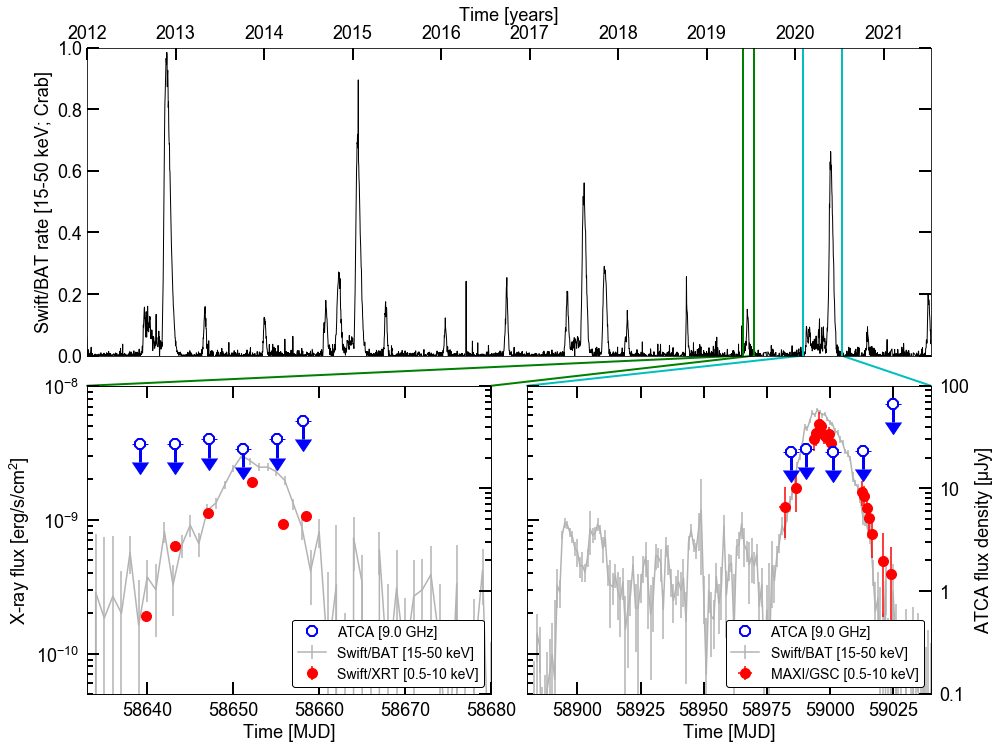

In [26]:
# Making the actual figure

fig = plt.figure(figsize=(cm2inch(4.*single_col),cm2inch(3.*single_col)))

########## TOP PANEL ##########
ax = fig.add_subplot(211)

## Setup of the basic figure: note the 211 since there will be a bottom row.
ax.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.set_xlim(55927,59409)
ax.set_ylim(0, 1)
ax.set_xticks(MJDyears_2012)
ax.set_xticklabels(Labelsyears_2012)

## Plotting the Swift BAT light curve in the top panel:
ax.plot(time, rate_Crab, 's-', color='k', ms=0, lw=1)

## Plotting the range for the zoom in the bottom panels:
ax.plot([58633,58633], [-1,100], 'g-', lw=2)
ax.plot([58680,58680], [-1,100], 'g-', lw=2)

ax.plot([58880,58880], [-1,100], 'c-', lw=2)
ax.plot([59040,59040], [-1,100], 'c-', lw=2)

## Settig the labels:
ax.set_xlabel('Time [years]', fontsize=FS)
ax.set_ylabel('Swift/BAT rate [15-50 keV; Crab]', fontsize=FS)

########## BOTTOM LEFT PANEL ##########
# This panel works the same as the bottom panel in Figure 1; see that code for comments

ax1 = fig.add_subplot(223)
ax2 = ax1.twinx()

for ax_i in [ax1,ax2]:
    ax_i.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=8)
    ax_i.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=8)

    ax_i.xaxis.set_ticks_position('both')
    ax_i.get_yaxis().set_tick_params(direction='in', which='both')
    ax_i.get_xaxis().set_tick_params(direction='in', which='both')

    ax_i.set_xlim(58633,58680)

##########    
ax1.errorbar(time, (2e-8)*rate_Crab, yerr=(2e-8)*error_Crab, fmt='s-', color='0.7', ms=0, label='Swift/BAT [15-50 keV]', zorder=0) #0.7
ax1.errorbar(swift_date, swift_flux, yerr=swift_dflux, fmt='ro', ms=10, label='Swift/XRT [0.5-10 keV]')

ax1.set_ylim(5e-11, 1e-8)
ax1.set_yscale('log')
ax1.set_ylabel(r'X-ray flux [erg/s/cm$^2$]', fontsize=FS)
ax1.set_xlabel('Time [MJD]', fontsize=FS)

ax1.plot([], [], 'w8', ms=10, mec='b', mew=2, label='ATCA [9.0 GHz]')

legend = ax1.legend(loc=4, fontsize=FS-4, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

##########

ax2.errorbar(ATCA_periastron_t, ATCA_periastron_Fhigh, yerr=ATCA_periastron_dFhigh, fmt='b8', ms=0, elinewidth=3, uplims=True, capsize=8)
ax2.plot(ATCA_periastron_t, ATCA_periastron_Fhigh, 'w8', ms=10, mec='b', mew=2)

ax2.set_yscale('log')
ax2.set_ylim(0.1, 100)

ax2.set_yticks([2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90], minor=True)
ax2.set_yticks([0.1,1,10,100], minor=False)
ax2.set_yticklabels([], minor=False)
ax2.set_yticklabels([], minor=True)

##########

con1 = ConnectionPatch(xyA=(58633,0.), xyB=(58633,1e-8), coordsA="data", coordsB="data", axesA=ax, axesB=ax1, color="g", lw=2)
con2 = ConnectionPatch(xyA=(58680,0.), xyB=(58680,1e-8), coordsA="data", coordsB="data", axesA=ax, axesB=ax1, color="g", lw=2)
ax.add_artist(con1)
ax.add_artist(con2)

########## BOTTOM RIGHT PANEL ##########
# This panel works the same as the bottom panel in Figure 1; see that code for comments

ax3 = fig.add_subplot(224)
ax4 = ax3.twinx()

for ax_i in [ax3,ax4]:
    ax_i.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=8)
    ax_i.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=8)

    ax_i.xaxis.set_ticks_position('both')
    ax_i.get_yaxis().set_tick_params(direction='in', which='both')
    ax_i.get_xaxis().set_tick_params(direction='in', which='both')

    ax_i.set_xlim(58880,59040) 

##########    
ax3.errorbar(time, (1e-8)*rate_Crab, yerr=(1e-8)*error_Crab, fmt='s-', color='0.7', ms=0, label='Swift/BAT [15-50 keV]', zorder=0) #0.7
ax3.errorbar(maxi_date, maxi_flux, xerr=maxi_ddate, yerr=maxi_dflux, fmt='ro', ms=10, label='MAXI/GSC [0.5-10 keV]')

ax3.set_ylim(5e-11, 1e-8)
ax3.set_yscale('log')
ax3.set_yticklabels([])
ax3.set_xlabel('Time [MJD]', fontsize=FS)

ax3.plot([], [], 'w8', ms=10, mec='b', mew=2, label='ATCA [9.0 GHz]')

legend = ax3.legend(loc=4, fontsize=FS-4, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

##########

ax4.errorbar(ATCA_giant_t, ATCA_giant_Fhigh, yerr=ATCA_giant_dFhigh, fmt='b8', ms=0, elinewidth=3, uplims=True, capsize=8)
ax4.plot(ATCA_giant_t, ATCA_giant_Fhigh, 'w8', ms=10, mec='b', mew=2)

ax4.set_yscale('log')
ax4.set_ylim(0.1, 100)
ax4.set_ylabel(r'ATCA flux density [$\mu$Jy]', fontsize=FS, color='k')

ax4.set_yticks([2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90], minor=True)
ax4.set_yticks([0.1,1,10,100], minor=False)
ax4.set_yticklabels([0.1, 1, 10,100], minor=False)
ax4.set_yticklabels(['','','','','','','','','','','','','','','',''], minor=True)

con3 = ConnectionPatch(xyA=(58880,0.), xyB=(58880,1e-8), coordsA="data", coordsB="data", axesA=ax, axesB=ax3, color="c", lw=2)
con4 = ConnectionPatch(xyA=(59040,0.), xyB=(59040,1e-8), coordsA="data", coordsB="data", axesA=ax, axesB=ax3, color="c", lw=2)
ax.add_artist(con3) 
ax.add_artist(con4)

plt.tight_layout()
plt.savefig('./Figure5/Figure5.png', dpi=500)

## Step 3: Plotting the discovery image of the radio counterpart of 1A 0535+262 (Fig. 3)

INFO: Setting slices=[0, 0] [aplpy.core]


/opt/anaconda3/envs/py27/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axis.py:1096: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.wa

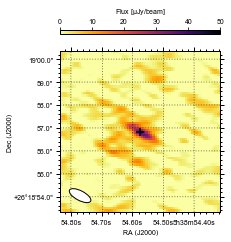

In [3]:
# Showing the image: this is what we are working with:
FS = 22
LS = 22
MS = 14
MEW= 1.5

# Set the colormap
CM = 'inferno_r' # binary

# Define the Fits file with the image
# I often also make a smaller image around the same centre position, to use in testing the code with faster plotting.
data = "./Figure3/obs2_image.fits"

# Define the image and the size:
fig = plt.figure(figsize=(cm2inch(single_col),cm2inch(single_col)))
plt.clf()

# Plot the map in the defined figure
cg = aplpy.FITSFigure(data, figure=fig, subplot=(1,1,1))
# Define the colormaps, min and max flux on the scale
cg.show_colorscale(cmap=CM,vmin=0.0,vmax=5e-5)

# Define the best radio position: centre on this. Remove this (including cg.recenter) to plot the entire field.
ra = 84.727396
dec = 26.315789
    
cg.recenter(ra, dec, radius=3.5/(60.*60.))  # radius in degrees

# Mark a position, in this case a '+' for the SIMBAD position of the source
cg.show_markers(ra, dec, layer='marker_set_1', 
                edgecolor=None, facecolor='k', marker='+', s=50)

# Add the beam
cg.add_beam()
cg.beam.show()
cg.beam.set_major(1.04 * u.arcsecond)
cg.beam.set_minor(0.42 * u.arcsecond)
cg.beam.set_angle(62.34 * u.degree)
cg.beam.set_corner('bottom left')
cg.beam.set_linestyle('-')
cg.beam.set_edgecolor('k')
cg.beam.set_facecolor('w')
cg.beam.set_linewidth(1)

# Set the properties of the axis labels and ticks:
cg.axis_labels.set_xpad(4)
cg.axis_labels.set_ypad(0)
cg.axis_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.tick_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.ticks.set_length(4)
cg.ticks.set_linewidth(1)
cg.ticks.set_color('black')

cg.frame.set_linewidth(1)  # points
cg.frame.set_color('black')

# Define the properties of the grid
cg.add_grid()
cg.grid.show()
cg.grid.set_color('k')
cg.grid.set_linestyle(':')
cg.grid.set_linewidth(1)

# Here comes some messy stuff: the colorbar never comes out beautifully for me in the default settings, so this
# defines a fake data set and plots it with imshow on a new axis, with the same colormap and min/max flux.
ax = fig.add_subplot(111)
fakedata = np.asarray([[],[]])
plt.imshow(fakedata,aspect='auto',origin='lower',vmin=0.0,vmax=5e-5,cmap=CM,rasterized=True)

# Then, I make a colorbar, and set all its properties; 
cb = plt.colorbar(orientation='horizontal', cmap=CM, shrink=1, aspect=40, pad=0, 
                  fraction=1.0,drawedges=True)

cb.set_label(r'Flux [$\mu$Jy/beam]', fontsize=7, fontweight='medium', family='arial', labelpad=5)
cb.set_ticks([0., 1e-5, 2e-5, 3e-5, 4e-5, 5e-5], update_ticks=True)
cb.set_ticklabels(['0', '10', '20', '30', '40', '50'])
cb.ax.xaxis.set_tick_params(pad=2)
cb.ax.tick_params(labelsize=7) 
cb.outline.set_linewidth(1)
cb.dividers.set_color('none')

# Make sure the color bar has ticks and labels at the top, since the bar is on the top as well. 
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

for l in cb.ax.xaxis.get_ticklabels():
    l.set_family("arial")
    
# Remove the axis for the 'fake' plot, that is only there for the colorbar.
ax.axis('off')

plt.tight_layout()
plt.savefig('./Figure3/Figure3.png', dpi=500)

## Step 4: plotting the X-ray / radio luminosity diagram (Figure 6 and 7)

### The entire diagram (Figure 6)

#### Reading in the comparison sample: strongly-magnetized neutron stars from Van den Eijnden et al. (2021) / A new radio census of accreting neutron stars"

In [22]:
radiodet, source, epoch, distance, freq, radio_flux, radio_rms, xraydet, lowE, xray_flux, xray_err1, xray_err2, spin, B, Bmeas, orbit, IncludeInPlot, Alpha, dAlpha = np.genfromtxt('./Figure6_7/MACHINEREADABLE_StrongB_RadioObservations.txt', dtype='str', delimiter=' ', comments='#', unpack=True)

Lr_conv = 1.196e24 # 1 microJansky at 1 kpc at 1 GHz in erg/s
Lx_conv = 1.196e44 # 1 erg/s/cm^2 at 1 kpc in erg/s

# Making the Strong B data more suitable for the plotting:
StrongB_lx_plot = []
StrongB_dlx_plot = []
StrongB_lr_plot = []
StrongB_dlr_plot = []
StrongB_spin_plot_det = []
StrongB_source_det = []
StrongB_Alpha_det = []
StrongB_dAlpha_det = []
used_freq = 6.
for i in xrange(len(source)):
    
    if radiodet[i] == '1' and xraydet[i] == '1' and IncludeInPlot[i] == '1':
        
        if float(xray_flux[i]) < 0:
            Lx_i = Lx_conv*(float(distance[i])**2)*(10**float(xray_flux[i]))
            dLx_i = -1.*((Lx_conv*(float(distance[i])**2)*(10**float(xray_err1[i])) - Lx_conv*(float(distance[i])**2)*(10**float(xray_err2[i])))/2.)
            
        else:
            Lx_i = Lx_conv*(float(distance[i])**2)*(float(xray_flux[i]))
            dLx_i = Lx_conv*(float(distance[i])**2)*(float(xray_err1[i]))
        
        Lr_i = Lr_conv*(float(distance[i])**2)*float(radio_flux[i])*used_freq
        dLr_i = Lr_conv*(float(distance[i])**2)*float(radio_rms[i])*used_freq
        
        StrongB_lx_plot.append(Lx_i)
        StrongB_dlx_plot.append(dLx_i)
        StrongB_lr_plot.append(Lr_i)
        StrongB_dlr_plot.append(dLr_i)
        StrongB_spin_plot_det.append(float(spin[i]))
        StrongB_source_det.append(source[i])
        StrongB_Alpha_det.append(float(Alpha[i]))
        StrongB_dAlpha_det.append(float(dAlpha[i]))
        
# Nondetection only in radio
StrongB_lx_UL1 = []
StrongB_dlx_UL1 = []
StrongB_lr_UL1 = []
StrongB_spin_plot_nodet = []
StrongB_source_nodet = []
for i in xrange(len(source)):
        
    if radiodet[i] == '0' and xraydet[i] == '1' and IncludeInPlot[i] == '1':
        
        if float(xray_flux[i]) < 0:
            Lx_i = Lx_conv*(float(distance[i])**2)*(10**float(xray_flux[i]))
            dLx_i = -1.*((Lx_conv*(float(distance[i])**2)*(10**float(xray_err1[i])) - Lx_conv*(float(distance[i])**2)*(10**float(xray_err2[i])))/2.)
            
        else:
            Lx_i = Lx_conv*(float(distance[i])**2)*(float(xray_flux[i]))
            dLx_i = Lx_conv*(float(distance[i])**2)*(float(xray_err1[i]))
        
        
        Lr_i = Lr_conv*(float(distance[i])**2)*float(radio_flux[i])*used_freq

        StrongB_lx_UL1.append(Lx_i)
        StrongB_dlx_UL1.append(dLx_i)
        StrongB_lr_UL1.append(Lr_i)
        StrongB_spin_plot_nodet.append(float(spin[i]))
        StrongB_source_nodet.append(source[i])
        
# Nondetection in both X-ray and radio
StrongB_lx_UL2 = []
StrongB_lr_UL2 = []
StrongB_source_nodet2 = []
StrongB_spin_plot_nodet2 = []
for i in xrange(len(source)):

    if radiodet[i] == '0' and xraydet[i] == '0' and IncludeInPlot[i] == '1':
        
        Lx_i = Lx_conv*(float(distance[i])**2)*float(xray_flux[i])
        Lr_i = Lr_conv*(float(distance[i])**2)*float(radio_flux[i])*used_freq
                
        StrongB_lx_UL2.append(Lx_i)
        StrongB_lr_UL2.append(Lr_i)
        StrongB_source_nodet2.append(source[i])
        StrongB_spin_plot_nodet2.append(float(spin[i]))
        
# Nondetection only in X-ray: Two sources, 4U 1954+31 and IGR J16318-4848
StrongB_lx_UL3 = []
StrongB_lr_UL3 = []
StrongB_dlr_UL3 = []
StrongB_spin_plot_UL3 = []
StrongB_source_UL3 = []
StrongB_Alpha_UL3 = []
StrongB_dAlpha_UL3 = []
for i in xrange(len(source)):
    
    if radiodet[i] == '1' and xraydet[i] == '0' and IncludeInPlot[i] == '1':

        if float(xray_flux[i]) < 0:    
            Lx_i = Lx_conv*(float(distance[i])**2)*(10**float(xray_flux[i]))
        else:
            Lx_i = Lx_conv*(float(distance[i])**2)*(float(xray_flux[i]))        
        
        Lr_i = Lr_conv*(float(distance[i])**2)*float(radio_flux[i])*used_freq
        dLr_i = Lr_conv*(float(distance[i])**2)*float(radio_rms[i])*used_freq

        StrongB_lx_UL3.append(Lx_i)
        StrongB_lr_UL3.append(Lr_i)
        StrongB_dlr_UL3.append(dLr_i)
        StrongB_spin_plot_UL3.append(float(spin[i]))
        StrongB_source_UL3.append(source[i])
        StrongB_Alpha_UL3.append(float(Alpha[i]))
        StrongB_dAlpha_UL3.append(float(dAlpha[i]))

#### Reading in the comparison sample: weakly-magnetized neutron stars from Van den Eijnden et al. (2021) / A new radio census of accreting neutron stars"

In [23]:
# Weak B NSs:

radiodet, source, epoch, distance, freq, radio_flux, radio_rms, xraydet, lowE, xray_flux, xray_err1, xray_err2, spin, orbit, IncludeInPlot, Alpha, dAlpha = np.genfromtxt('./Figure6_7/MACHINEREADABLE_WeakB_RadioObservations.txt', dtype='str', delimiter=' ', comments='#', unpack=True)

Lr_conv = 1.196e24 # 1 microJansky at 1 kpc at 1 GHz in erg/s
Lx_conv = 1.196e44 # 1 erg/s/cm^2 at 1 kpc in erg/s

# Making the Weak B data more suitable for the plotting:
WeakB_lx_plot = []
WeakB_dlx_plot = []
WeakB_lr_plot = []
WeakB_dlr_plot = []
WeakB_spin_plot_det = []
WeakB_source_det = []
WeakB_Alpha_det = []
WeakB_dAlpha_det = []
for i in xrange(len(source)):    
    if radiodet[i] == '1' and xraydet[i] == '1' and IncludeInPlot[i] == '1':
        
        if float(xray_flux[i]) < 0:
            Lx_i = Lx_conv*(float(distance[i])**2)*(10**float(xray_flux[i]))
            dLx_i = -1.*((Lx_conv*(float(distance[i])**2)*(10**float(xray_err1[i])) - Lx_conv*(float(distance[i])**2)*(10**float(xray_err2[i])))/2.)
            
        else:
            Lx_i = Lx_conv*(float(distance[i])**2)*(float(xray_flux[i]))
            dLx_i = Lx_conv*(float(distance[i])**2)*(float(xray_err1[i]))
        
        Lr_i = Lr_conv*(float(distance[i])**2)*float(radio_flux[i])*used_freq
        dLr_i = Lr_conv*(float(distance[i])**2)*float(radio_rms[i])*used_freq
        
        WeakB_lx_plot.append(Lx_i)
        WeakB_dlx_plot.append(dLx_i)
        WeakB_lr_plot.append(Lr_i)
        WeakB_dlr_plot.append(dLr_i)
        WeakB_spin_plot_det.append(float(spin[i]))
        WeakB_source_det.append(source[i])
        WeakB_Alpha_det.append(float(Alpha[i]))
        WeakB_dAlpha_det.append(float(dAlpha[i]))

#### Reading in the X-ray -- radio luminosity data for the three studied targets:

In [24]:
# The distances and errors from Gaia

D_a0535 = 1.79 * u.kpc
dD_a0535 = 0.08 * u.kpc

D_saxj2103 = 6.23 * u.kpc 
dD_saxj2103 = 0.55 * u.kpc 

D_J1008 = 3.55 * u.kpc 
dD_J1008 = 0.17 * u.kpc 

D_J1008giant = D_J1008
D_J1008per = D_J1008

D_SwJ0243 = 5.21 * u.kpc
dD_SwJ0243 = 0.32 * u.kpc

In [25]:
## 1A 0535+262

lxlr_a0535 = np.genfromtxt('./Figure6_7/a0535.lxlr.plotting_data.txt',unpack=True)

lx_05_10_a0535 = (4*np.pi*(lxlr_a0535[4]*u.erg/u.s/u.cm**2)*(D_a0535**2)).to(u.erg / u.s).value
dlx_05_10_a0535 = (4*np.pi*(lxlr_a0535[5]*u.erg/u.s/u.cm**2)*(D_a0535**2)).to(u.erg / u.s).value

lr_a0535 = (4*np.pi*(lxlr_a0535[1]*u.microJansky)*(6.0 * u.GHz)*(D_a0535**2)).to(u.erg / u.s).value
dlr_a0535 = (4*np.pi*(lxlr_a0535[2]*u.microJansky)*(6.0 * u.GHz)*(D_a0535**2)).to(u.erg / u.s).value

## SAX J2103.5+4545

lxlr_saxj2103 = np.genfromtxt('./Figure6_7/saxj2103.lxlr.plotting_data.txt',unpack=True)

lx_05_10_saxj2103 = (4*np.pi*(lxlr_saxj2103[4]*u.erg/u.s/u.cm**2)*(D_saxj2103**2)).to(u.erg / u.s).value
dlx_05_10_saxj2103 = (4*np.pi*(lxlr_saxj2103[5]*u.erg/u.s/u.cm**2)*(D_saxj2103**2)).to(u.erg / u.s).value

lr_saxj2103 = (4*np.pi*(lxlr_saxj2103[1]*u.microJansky)*(6.0 * u.GHz)*(D_saxj2103**2)).to(u.erg / u.s).value
dlr_saxj2103 = (4*np.pi*(lxlr_saxj2103[2]*u.microJansky)*(6.0 * u.GHz)*(D_saxj2103**2)).to(u.erg / u.s).value

## GRO J1008-57 periastron

lxlr_J1008per = np.genfromtxt('./Figure6_7/J1008.periastron.lxlr.plotting_data.txt',unpack=True)

lx_05_10_J1008per = (4*np.pi*(lxlr_J1008per[4]*u.erg/u.s/u.cm**2)*(D_J1008per**2)).to(u.erg / u.s).value
dlx_05_10_J1008per = (4*np.pi*(lxlr_J1008per[5]*u.erg/u.s/u.cm**2)*(D_J1008per**2)).to(u.erg / u.s).value

lr_J1008per = (4*np.pi*(lxlr_J1008per[1]*u.microJansky)*(6.0 * u.GHz)*(D_J1008per**2)).to(u.erg / u.s).value
dlr_J1008per = (4*np.pi*(lxlr_J1008per[2]*u.microJansky)*(6.0 * u.GHz)*(D_J1008per**2)).to(u.erg / u.s).value

## GRO J1008-57 giant

maxi_factor = 0.7
lxlr_J1008giant = np.genfromtxt('./Figure6_7/J1008.giant.lxlr.plotting_data.txt',unpack=True)

lx_05_10_J1008giant = (4*np.pi*(maxi_factor*lxlr_J1008giant[4]*u.erg/u.s/u.cm**2)*(D_J1008giant**2)).to(u.erg / u.s).value
dlx_05_10_J1008giant = (4*np.pi*(maxi_factor*lxlr_J1008giant[5]*u.erg/u.s/u.cm**2)*(D_J1008giant**2)).to(u.erg / u.s).value

lr_J1008giant = (4*np.pi*(lxlr_J1008giant[1]*u.microJansky)*(6.0 * u.GHz)*(D_J1008giant**2)).to(u.erg / u.s).value
dlr_J1008giant = (4*np.pi*(lxlr_J1008giant[2]*u.microJansky)*(6.0 * u.GHz)*(D_J1008giant**2)).to(u.erg / u.s).value

#### Creating the Figure:

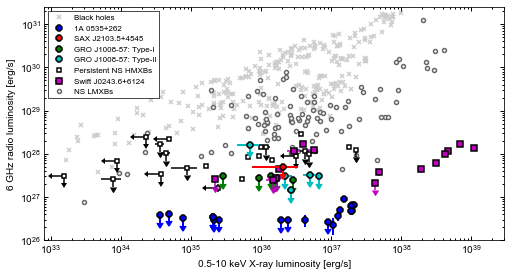

In [26]:
### paper plot Lx Lr:

FS  = 10
LS  = 10
MS  = 6
MEW = 2

###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(double_col),cm2inch(10)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=1, length=4, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=2, width=1, axis='both', which='minor', pad=3)

ax.set_xscale('log')
ax.set_yscale('log')
    
ax.set_xlim(8e32, 3e39) #33
ax.set_ylim(1e26, 2.5e31) #26
ax.set_xticks([1e33, 1e34, 1e35, 1e36, 1e37, 1e38, 1e39])
ax.set_xticklabels([r'$10^{33}$', r'$10^{34}$', r'$10^{35}$', r'$10^{36}$', r'$10^{37}$', r'$10^{38}$', r'$10^{39}$'])
ax.set_yticks([1e26, 1e27, 1e28, 1e29, 1e30, 1e31])
ax.set_yticklabels([r'$10^{26}$', r'$10^{27}$', r'$10^{28}$', r'$10^{29}$', r'$10^{30}$', r'$10^{31}$'])

ax.set_xlabel('0.5-10 keV X-ray luminosity [erg/s]', fontsize=FS)
ax.set_ylabel('6 GHz radio luminosity [erg/s]', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################    
### reading in and plotting the black holes:
###############################################################################################################
BH_lx, BH_lr, BH_det = np.genfromtxt('./Figure6_7/BH_Lx_Lr.txt', dtype='str', delimiter=' ', 
                                              comments='#', unpack=True, usecols=[0,1,2])

BH_lx_plot = []
BH_lr_plot = []
for i in xrange(len(BH_lx)):
    if '1' in BH_det[i]:
        BH_lx_plot.append(float(BH_lx[i]))
        BH_lr_plot.append(float(BH_lr[i]))
        
ax.plot(np.power(10., BH_lx_plot), np.power(10., np.asarray(BH_lr_plot)), 'x', c='0.8', 
        ms=4, mew=1.5, label='Black holes',zorder=0)

###############################################################################################################
### Reading in and plotting the weak B neutron stars from Gallo et al. 2018:
###############################################################################################################
NS_lx, NS_lr, NS_det, NS_type = np.genfromtxt('./Figure6_7/NS_Lx_Lr.txt', dtype='str', delimiter='\t', 
                                              comments='#', unpack=True, usecols=[1,2,3,4])

NS_lx_plot = []
NS_lr_plot = []
NS_type_plot = []
for i in xrange(len(NS_lr)):
    if NS_det[i] == '1':
        NS_lx_plot.append(float(NS_lx[i]))
        NS_lr_plot.append(float(NS_lr[i]))
        NS_type_plot.append(NS_type[i])
    
Cs = {'1':'w', '2':'w', '3':'w', '4':'w'}
MS = {'1':4, '2':4, '3':4, '4':4}
for i in xrange(len(NS_lx_plot)):
    Lx = 10**NS_lx_plot[i]
    
    Lr = (6./5.)*(10**NS_lr_plot[i]) 
    
    ax.plot(Lx, Lr, 'o', color=Cs[NS_type_plot[i]], ms=MS[NS_type_plot[i]], mew=1.5, markeredgecolor='0.4',zorder=0)#='0.6')
    
###############################################################################################################    
### Plotting the strong B NSs
###############################################################################################################

for i in xrange(len(StrongB_lx_UL1)):
    if StrongB_source_nodet[i] == 'SwiftJ0243.6p6124':
        ax.errorbar(StrongB_lx_UL1[i], StrongB_lr_UL1[i], xerr=StrongB_dlx_UL1[i], 
                    yerr=np.asarray(StrongB_lr_UL1)[i]/3., fmt='o', color='m', ms=0, mew=1., mec='k', uplims=True,zorder=5)
        ax.plot(StrongB_lx_UL1[i], StrongB_lr_UL1[i], 'sm', ms=6, mew=1.5, mec='k',zorder=5)
    else:
        ax.errorbar(StrongB_lx_UL1[i], StrongB_lr_UL1[i], xerr=StrongB_dlx_UL1[i], 
                    yerr=np.asarray(StrongB_lr_UL1)[i]/3., fmt='o', color='k', ms=0, mew=1., mec='k', uplims=True, zorder=1)
        ax.plot(StrongB_lx_UL1[i], StrongB_lr_UL1[i], 'sw', ms=4, mew=1.5, mec='k', zorder=1)

# Next ones: cases without Sw J0242 (double ULs)
ax.errorbar(StrongB_lx_UL2, StrongB_lr_UL2, xerr=np.asarray(StrongB_lx_UL2)/3., yerr=np.asarray(StrongB_lr_UL2)/3.,
            fmt='o', color='k', ms=0, mew=0., mec='k', uplims=True, xuplims=True, zorder=1)
ax.plot(StrongB_lx_UL2, StrongB_lr_UL2, 'sw', ms=4, mew=1.5, mec='k', zorder=1)

# Next ones: cases without Sw J0243 (only UL in x-rays)
ax.errorbar(StrongB_lx_UL3, StrongB_lr_UL3, xerr=np.asarray(StrongB_lx_UL3)/3., yerr=np.asarray(StrongB_dlr_UL3),
            fmt='o', color='k', ms=0, mew=0., mec='k', xuplims=True, zorder=1)
ax.plot(StrongB_lx_UL3, StrongB_lr_UL3, 'sw', ms=4, mew=1.5, mec='k', zorder=1)

# Next ones: detections in both: contains Sw J0243
for i in xrange(len(StrongB_lx_plot)):
    if StrongB_source_det[i] == 'SwiftJ0243.6p6124':
        ax.errorbar(StrongB_lx_plot[i], StrongB_lr_plot[i] , xerr=StrongB_dlx_plot[i],
                    yerr=StrongB_dlr_plot[i], fmt='s', color='m', ms=6, mew=1.5, markeredgecolor='k')
    else:
        ax.errorbar(StrongB_lx_plot[i], StrongB_lr_plot[i] , xerr=StrongB_dlx_plot[i],
                    yerr=StrongB_dlr_plot[i], fmt='s', color='w', ms=4, mew=1.5, markeredgecolor='k', zorder=1)

ax.errorbar([],[],xerr=[], yerr=[], fmt='s', color='w', ms=4, mew=1.5, markeredgecolor='k', label='Persistent NS HMXBs')
ax.errorbar([],[],xerr=[], yerr=[], fmt='s', color='m', ms=6, mew=1.5, markeredgecolor='k', label='Swift J0243.6+6124')

###############################################################################################################    
### Plotting the weak B NSs
###############################################################################################################

ax.errorbar(WeakB_lx_plot, WeakB_lr_plot , xerr=WeakB_dlx_plot,
            yerr=WeakB_dlr_plot, fmt='o', color='w', ms=4, mew=1.5, markeredgecolor='0.4', label=r'NS LMXBs',zorder=0)

###############################################################################################################    
### Plotting the transient BeXRBs
###############################################################################################################

ax.errorbar(lx_05_10_a0535, lr_a0535, xerr=dlx_05_10_a0535, yerr=dlr_a0535, 
            fmt='b8', mew=1.5, mec='k', ms=6, elinewidth=2, uplims=lxlr_a0535[3], zorder=3)

ax.errorbar(lx_05_10_saxj2103, lr_saxj2103, xerr=dlx_05_10_saxj2103, yerr=dlr_saxj2103, 
            fmt='r8', mew=1.5, mec='k', ms=6, elinewidth=2, uplims=lxlr_saxj2103[3], zorder=4)

ax.errorbar(lx_05_10_J1008per, lr_J1008per, xerr=dlx_05_10_J1008per, yerr=dlr_J1008per, 
            fmt='g8', mew=1.5, mec='k', ms=6, elinewidth=2, uplims=lxlr_J1008per[3], zorder=3)

ax.errorbar(lx_05_10_J1008giant, lr_J1008giant, xerr=dlx_05_10_J1008giant, yerr=dlr_J1008giant, 
            fmt='c8', mew=1.5, mec='k', ms=6, elinewidth=2, uplims=lxlr_J1008giant[3], zorder=3)

ax.plot([],[],'b8', mew=1.5, mec='k', ms=6, label='1A 0535+262')
ax.plot([],[],'r8', mew=1.5, mec='k', ms=6, label=r'SAX J2103.5+4545')
ax.plot([],[],'g8', mew=1.5, mec='k', ms=6, label=r'GRO J1008-57: Type-I')
ax.plot([],[],'c8', mew=1.5, mec='k', ms=6, label=r'GRO J1008-57: Type-II')

###############################################################################################################
### Making the legend:
###############################################################################################################

### The legend:
leg = ax.legend(loc=2, frameon=True, fontsize=8, ncol=1, numpoints=1, fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.7)

###############################################################################################################
plt.tight_layout()
plt.savefig('./Figure6_7/Figure6.png', dpi=500)

### Highlighting the points of GRO J1008-57:

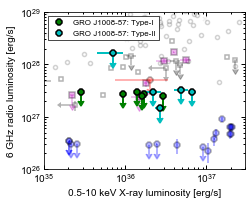

In [27]:
### paper plot Lx Lr:

FS  = 10
LS  = 10
MS  = 6
MEW = 2

###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(0.5*double_col),cm2inch(7.5)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=1, length=4, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=2, width=1, axis='both', which='minor', pad=3)

ax.set_xscale('log')
ax.set_yscale('log')
    
ax.set_xlim(1e35, 3e37) #33
ax.set_ylim(1e26, 1e29) #26
ax.set_xticks([1e35,1e36, 1e37])
ax.set_xticklabels([r'$10^{35}$', r'$10^{36}$', r'$10^{37}$'])
ax.set_yticks([1e26, 1e27, 1e28, 1e29])
ax.set_yticklabels([r'$10^{26}$', r'$10^{27}$', r'$10^{28}$', r'$10^{29}$'])

ax.set_xlabel('0.5-10 keV X-ray luminosity [erg/s]', fontsize=FS)
ax.set_ylabel('6 GHz radio luminosity [erg/s]', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################    
### reading in and plotting the black holes:
###############################################################################################################
BH_lx, BH_lr, BH_det = np.genfromtxt('./Figure6_7/BH_Lx_Lr.txt', dtype='str', delimiter=' ', 
                                              comments='#', unpack=True, usecols=[0,1,2])

BH_lx_plot = []
BH_lr_plot = []
for i in xrange(len(BH_lx)):
    if '1' in BH_det[i]:
        BH_lx_plot.append(float(BH_lx[i]))
        BH_lr_plot.append(float(BH_lr[i]))
        
ax.plot(np.power(10., BH_lx_plot), np.power(10., np.asarray(BH_lr_plot)), 'x', c='0.8', 
        ms=4, mew=1.5, zorder=0, alpha=0.3)

###############################################################################################################
### Reading in and plotting the weak B neutron stars:
###############################################################################################################
NS_lx, NS_lr, NS_det, NS_type = np.genfromtxt('./Figure6_7/NS_Lx_Lr.txt', dtype='str', delimiter='\t', 
                                              comments='#', unpack=True, usecols=[1,2,3,4])

NS_lx_plot = []
NS_lr_plot = []
NS_type_plot = []
for i in xrange(len(NS_lr)):
    if NS_det[i] == '1':
        NS_lx_plot.append(float(NS_lx[i]))
        NS_lr_plot.append(float(NS_lr[i]))
        NS_type_plot.append(NS_type[i])
    
Cs = {'1':'w', '2':'w', '3':'w', '4':'w'}
MS = {'1':4, '2':4, '3':4, '4':4}
for i in xrange(len(NS_lx_plot)):
    Lx = 10**NS_lx_plot[i]
    
    Lr = (6./5.)*(10**NS_lr_plot[i]) 
    
    ax.plot(Lx, Lr, 'o', color=Cs[NS_type_plot[i]], ms=MS[NS_type_plot[i]], mew=1.5, 
            markeredgecolor='0.4',zorder=0, alpha=0.3)
    
###############################################################################################################    
### Plotting the strong B NSs
###############################################################################################################

for i in xrange(len(StrongB_lx_UL1)):
    if StrongB_source_nodet[i] == 'SwiftJ0243.6p6124':
        ax.errorbar(StrongB_lx_UL1[i], StrongB_lr_UL1[i], xerr=StrongB_dlx_UL1[i], 
                    yerr=np.asarray(StrongB_lr_UL1)[i]/3., fmt='o', color='m', ms=0, mew=1., mec='k', 
                    uplims=True,zorder=5, alpha=0.3)
        ax.plot(StrongB_lx_UL1[i], StrongB_lr_UL1[i], 'sm', ms=6, mew=1.5, mec='k',zorder=5, alpha=0.3)
    else:
        ax.errorbar(StrongB_lx_UL1[i], StrongB_lr_UL1[i], xerr=StrongB_dlx_UL1[i], 
                    yerr=np.asarray(StrongB_lr_UL1)[i]/3., fmt='o', color='k', ms=0, mew=1., 
                    mec='k', uplims=True, zorder=1, alpha=0.3)
        ax.plot(StrongB_lx_UL1[i], StrongB_lr_UL1[i], 'sw', ms=4, mew=1.5, mec='k', zorder=1, alpha=0.3)

# Next ones: cases without Sw J0242 (double ULs)
ax.errorbar(StrongB_lx_UL2, StrongB_lr_UL2, xerr=np.asarray(StrongB_lx_UL2)/3., yerr=np.asarray(StrongB_lr_UL2)/3.,
            fmt='o', color='k', ms=0, mew=0., mec='k', uplims=True, xuplims=True, zorder=1, alpha=0.3)
ax.plot(StrongB_lx_UL2, StrongB_lr_UL2, 'sw', ms=4, mew=1.5, mec='k', zorder=1, alpha=0.3)

# Next ones: cases without Sw J0243 (only UL in x-rays)
ax.errorbar(StrongB_lx_UL3, StrongB_lr_UL3, xerr=np.asarray(StrongB_lx_UL3)/3., yerr=np.asarray(StrongB_dlr_UL3),
            fmt='o', color='k', ms=0, mew=0., mec='k', xuplims=True, zorder=1, alpha=0.3)
ax.plot(StrongB_lx_UL3, StrongB_lr_UL3, 'sw', ms=4, mew=1.5, mec='k', zorder=1, alpha=0.3)

# Next ones: detections in both: contains Sw J0243
for i in xrange(len(StrongB_lx_plot)):
    if StrongB_source_det[i] == 'SwiftJ0243.6p6124':
        ax.errorbar(StrongB_lx_plot[i], StrongB_lr_plot[i] , xerr=StrongB_dlx_plot[i],
                    yerr=StrongB_dlr_plot[i], fmt='s', color='m', ms=6, mew=1.5, markeredgecolor='k', alpha=0.3)
    else:
        ax.errorbar(StrongB_lx_plot[i], StrongB_lr_plot[i] , xerr=StrongB_dlx_plot[i],
                    yerr=StrongB_dlr_plot[i], fmt='s', color='w', ms=4, mew=1.5, 
                    markeredgecolor='k', zorder=1, alpha=0.3)

###############################################################################################################    
### Plotting the weak B NSs
###############################################################################################################

ax.errorbar(WeakB_lx_plot, WeakB_lr_plot , xerr=WeakB_dlx_plot,
            yerr=WeakB_dlr_plot, fmt='o', color='w', ms=4, mew=1.5, markeredgecolor='0.4',zorder=0, alpha=0.3)

###############################################################################################################    
### Plotting the transient BeXRBs
###############################################################################################################

ax.errorbar(lx_05_10_a0535, lr_a0535, xerr=dlx_05_10_a0535, yerr=dlr_a0535, 
            fmt='b8', mew=1.5, mec='k', ms=6, elinewidth=2, uplims=lxlr_a0535[3], zorder=3, alpha=0.3)

ax.errorbar(lx_05_10_saxj2103, lr_saxj2103, xerr=dlx_05_10_saxj2103, yerr=dlr_saxj2103, 
            fmt='r8', mew=1.5, mec='k', ms=6, elinewidth=2, uplims=lxlr_saxj2103[3], zorder=4, alpha=0.3)

ax.errorbar(lx_05_10_J1008per, lr_J1008per, xerr=dlx_05_10_J1008per, yerr=dlr_J1008per, 
            fmt='g8', mew=1.5, mec='k', ms=6, elinewidth=2, uplims=lxlr_J1008per[3], zorder=10)

ax.errorbar(lx_05_10_J1008giant, lr_J1008giant, xerr=dlx_05_10_J1008giant, yerr=dlr_J1008giant, 
            fmt='c8', mew=1.5, mec='k', ms=6, elinewidth=2, uplims=lxlr_J1008giant[3], zorder=10)

ax.plot([],[],'g8', mew=1.5, mec='k', ms=6, label=r'GRO J1008-57: Type-I')
ax.plot([],[],'c8', mew=1.5, mec='k', ms=6, label=r'GRO J1008-57: Type-II')

###############################################################################################################
### Making the legend:
###############################################################################################################

### The legend:
leg = ax.legend(loc=2, frameon=True, fontsize=8, ncol=1, numpoints=1, fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.7)

###############################################################################################################
plt.tight_layout()
plt.savefig('./Figure6_7/Figure7.png', dpi=500)

## Step 5: Performing the MCMC linmix fit to all BeXRB giant outburst points (Fig. 8 and Online Supplementary Materials Figure 5):

### Reading in and selecting the data to consider:

In [28]:
# Reading in the nondetections of the sources, and defining the delta parameter which is 0 for a non-detection, 
# and 1 for a detection. This will be used as input for the linmix analysis later.
radio_nondet_a0535 = lxlr_a0535[3]
delta_a0535 = np.abs(radio_nondet_a0535-1)

radio_nondet_saxj2103 = lxlr_saxj2103[3]
delta_saxj2103 = np.abs(radio_nondet_saxj2103-1)

radio_nondet_J1008giant = lxlr_J1008giant[3]
delta_J1008giant = np.abs(radio_nondet_J1008giant-1)

# read in the data for Swift J0243:
lx_05_10_SwJ0243, lr_SwJ0243, dlx_05_10_SwJ0243, dlr_SwJ0243, delta_SwJ0243 = np.genfromtxt('./MCMC_Fitting_and_Figure8/lxlr_swJ0243.txt', unpack=True)

In [31]:
## Here, we create arrays of all the consider X-ray and radio flux (densities) and errors, as well as 
## the signifier of detection, regardless of the target. 

lx = []
dlx = []
lr = []
dlr = []
delta = []

## For all considered data, we also add it to a separate list when the observation returned a detection.
## Using these detected points, we will calculate a mean X-ray and radio luminosity. 
lx0_calc = []
dlx0_calc = []
lr0_calc = []
dlr0_calc = []

# For A0535+262, we select the entire outburst since all data is from the giant outburst.
for i in xrange(len(lx_05_10_a0535)):
    lx.append(lx_05_10_a0535[i])
    dlx.append(dlx_05_10_a0535[i]) 
    lr.append(lr_a0535[i])
    dlr.append(dlr_a0535[i])
    delta.append(delta_a0535[i])
    if delta_a0535[i] == 1:
        lx0_calc.append(lx_05_10_a0535[i])
        lr0_calc.append(lr_a0535[i])
        
        dlx0_calc.append(dlx_05_10_a0535[i])
        dlr0_calc.append(dlr_a0535[i])

# For GRO J1008-57, we only select the giant outburst in 2020:
for i in xrange(len(lx_05_10_J1008giant)):
    lx.append(lx_05_10_J1008giant[i])
    dlx.append(dlx_05_10_J1008giant[i]) 
    lr.append(lr_J1008giant[i])
    dlr.append(dlr_J1008giant[i])
    delta.append(delta_J1008giant[i])
    if delta_J1008giant[i] == 1:
        lx0_calc.append(lx_05_10_J1008giant[i])
        lr0_calc.append(lr_J1008giant[i])
        
        dlx0_calc.append(dlx_05_10_J1008giant[i])
        dlr0_calc.append(dlr_J1008giant[i])

# For Swift J0243.6+6124, we only select the main outburst:
for i in xrange(len(lx_05_10_SwJ0243)):
    lx.append(lx_05_10_SwJ0243[i])
    dlx.append(dlx_05_10_SwJ0243[i]) 
    lr.append(lr_SwJ0243[i])
    dlr.append(dlr_SwJ0243[i])
    delta.append(delta_SwJ0243[i])
    if delta_SwJ0243[i] == 1:
        lx0_calc.append(lx_05_10_SwJ0243[i])
        lr0_calc.append(lr_SwJ0243[i])
        
        dlx0_calc.append(dlx_05_10_SwJ0243[i])
        dlr0_calc.append(dlr_SwJ0243[i])

# For Sax J2103.5+4545, we have just one point, so there is no loop; this is a non-detection:
lx.append(lx_05_10_saxj2103)
dlx.append(dlx_05_10_saxj2103) 
lr.append(lr_saxj2103)
dlr.append(dlr_saxj2103)
delta.append(delta_saxj2103)

# Turning the lists into arrays 
lx = np.asarray(lx)
dlx = np.asarray(dlx)
lr = np.asarray(lr)
dlr = np.asarray(dlr)
delta = np.asarray(delta)

lx0_calc = np.asarray(lx0_calc)
dlx0_calc = np.asarray(dlx0_calc)
lr0_calc = np.asarray(lr0_calc)
dlr0_calc = np.asarray(dlr0_calc)

# Calculating the average of the X-ray and radio detections:
lx0 = np.mean(lx0_calc)
lr0 = np.mean(lr0_calc)

# Converting all values to log space, since the linmix methods required the fit to be linearized.
# We also scale all values to the means:
lx_scaled = lx/lx0
dlx_scaled_p = (lx+dlx)/lx0
dlx_scaled_m = (lx-dlx)/lx0

log_lx_scaled = np.log10(lx_scaled)
log_dlx_scaled_p = np.log10(dlx_scaled_p)
log_dlx_scaled_m = np.log10(dlx_scaled_m)
log_dlx_scaled = (log_dlx_scaled_p - log_dlx_scaled_m)/2.

lr_scaled = lr/lr0
dlr_scaled_p = (lr+dlr)/lr0
dlr_scaled_m = (lr-dlr)/lr0

log_lr_scaled = np.log10(lr_scaled)
log_dlr_scaled_p = np.log10(dlr_scaled_p)
log_dlr_scaled_m = np.log10(dlr_scaled_m)
log_dlr_scaled = (log_dlr_scaled_p - log_dlr_scaled_m)/2.

In [32]:
print r"L_{X,0} =", lx0, "erg/s"
print r"L_{R,0} =", lr0, "erg/s"

$L_{X,0} = 2.0166088838527146e+38 erg/s
$L_{R,0} = 4.198556386987543e+27 erg/s


### Run a first example chain, to show that we can obtain a proper fit:

In [33]:
lm = linmix.LinMix(x=log_lx_scaled, y=log_lr_scaled, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta,K=3)
lm.run_mcmc(miniter=5000,silent=True)

In [34]:
# Extract the fitted parameters for Alpha* (== Xi in the paper), Beta, and Sigma
# * Here, we use alpha to stick to the nomenclature of the linmix documentation

alphas = []
betas = []
sigmas = []
for i in xrange(len(lm.chain)):
    alphas.append(lm.chain[i]['alpha'])
    betas.append(lm.chain[i]['beta'])
    sigmas.append(lm.chain[i]['sigsqr'])
    
# Creating histograms:    
alpha_counts, alpha_edges = np.histogram(alphas, bins=100, density=True)
beta_counts, beta_edges = np.histogram(betas, bins=100, density=True)
sigma_counts, sigma_edges = np.histogram(sigmas, bins=500, range=[0,2], density=True)

# Finding the 16th and 84th percentiles for alpha
sixteen=True
eightyfour=True
fifty=True
for X in xrange(len(alpha_counts)):
    if sum(alpha_counts[:X]*(alpha_edges[1:X+1]-alpha_edges[:X])) > 0.16 and sixteen:
        alpha_16 = (alpha_edges[X-1]+alpha_edges[X])/2.
        sixteen = False
    
    if sum(alpha_counts[:X]*(alpha_edges[1:X+1]-alpha_edges[:X])) > 0.50 and fifty:
        alpha_50 = (alpha_edges[X-1]+alpha_edges[X])/2.
        fifty = False
        
    if sum(alpha_counts[:X]*(alpha_edges[1:X+1]-alpha_edges[:X])) > 0.84 and eightyfour:
        alpha_84 = (alpha_edges[X-1]+alpha_edges[X])/2.
        eightyfour = False
        
    if alpha_counts[X] == max(alpha_counts):
        alpha_mode = (alpha_edges[X-1]+alpha_edges[X])/2.
alpha_mean = np.mean(alphas)

# Finding the 16th and 84th percentiles for beta
sixteen=True
eightyfour=True
fifty=True
for X in xrange(len(beta_counts)):
    if sum(beta_counts[:X]*(beta_edges[1:X+1]-beta_edges[:X])) > 0.16 and sixteen:
        beta_16 = (beta_edges[X-1]+beta_edges[X])/2.
        sixteen = False
    
    if sum(beta_counts[:X]*(beta_edges[1:X+1]-beta_edges[:X])) > 0.50 and fifty:
        beta_50 = (beta_edges[X-1]+beta_edges[X])/2.
        fifty = False
        
    if sum(beta_counts[:X]*(beta_edges[1:X+1]-beta_edges[:X])) > 0.84 and eightyfour:
        beta_84 = (beta_edges[X-1]+beta_edges[X])/2.
        eightyfour = False
        
    if beta_counts[X] == max(beta_counts):
        beta_mode = (beta_edges[X-1]+beta_edges[X])/2.
beta_mean = np.mean(betas)

In [35]:
# Defining a function that can plot histograms using the output of np.histogram and a defined axis:

def hist_plotter(ax, edges, counts, C='k', LW=2, normalized_to_one=True, label='', ALPHA=1.0):
    
    if normalized_to_one:
        counts = counts/float(max(counts))
    
    ax.plot([edges[0]]*2, [0, counts[0]], lw=LW, color=C, label=label, alpha=ALPHA)
    ax.plot([edges[-1]]*2, [counts[-1], 0], lw=LW, color=C, alpha=ALPHA)
    for i in xrange(len(edges)-1):
        ax.plot([edges[i], edges[i+1]], [counts[i]]*2, lw=LW, color=C, alpha=ALPHA)
        if i != 0:
            ax.plot([edges[i]]*2, [counts[i-1],counts[i]], lw=LW, color=C, alpha=ALPHA)
            
    return

FS  = 20
LS  = 20
MS  = 10
MEW = 3

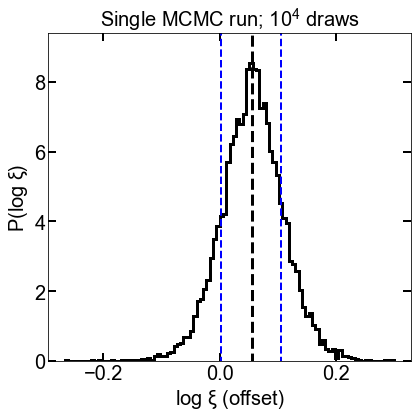

In [36]:
# Plotting the outcome of this single run for beta:

###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(alpha_counts))

ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=alpha_edges, counts=alpha_counts, LW=3, normalized_to_one=False)

ax.plot([alpha_16,alpha_16], [-1,1000], 'b--', lw=2)
ax.plot([alpha_84,alpha_84], [-1,1000], 'b--', lw=2)

#ax.plot([alpha_50,alpha_50], [-1,1000], 'b-', lw=2)
#ax.plot([alpha_mode,alpha_mode], [-1,1000], 'r-', lw=2)
ax.plot([alpha_mean,alpha_mean], [-1,1000], 'k--', lw=3)

ax.set_title('Single MCMC run; $10^4$ draws', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/logxi_example_singlerun.png', dpi=500)

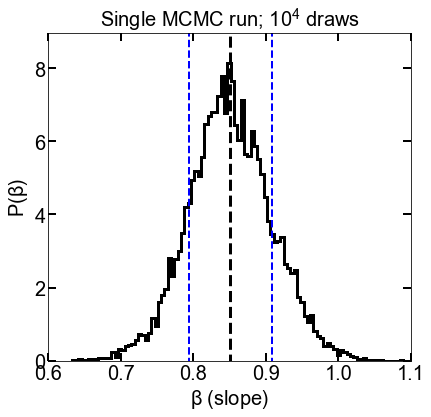

In [37]:
# Plotting the outcome of this single test run for beta:

###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(beta_counts))
ax.set_xlim(0.6,1.1)

ax.set_xlabel(r'$\beta$ (slope)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=beta_edges, counts=beta_counts, LW=3, normalized_to_one=False)

ax.plot([beta_16,beta_16], [-1,1000], 'b--', lw=2)
ax.plot([beta_84,beta_84], [-1,1000], 'b--', lw=2)
ax.plot([beta_mean,beta_mean], [-1,1000], 'k--', lw=3)

ax.set_title('Single MCMC run; $10^4$ draws', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/beta_example_singlerun.png', dpi=500)

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


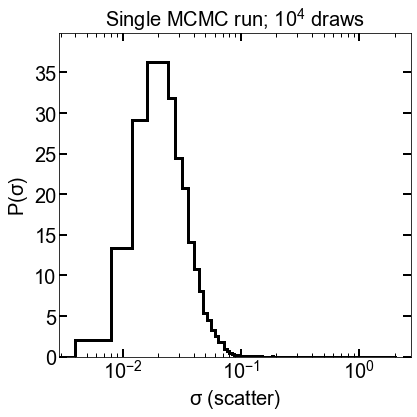

In [38]:
# Plotting the outcome of this single test run for sigma:

###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_xscale('log')
ax.set_ylim(0, 1.1*max(sigma_counts))

ax.set_xlabel(r'$\sigma$ (scatter)', fontsize=FS)
ax.set_ylabel(r'$P(\sigma)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=sigma_edges, counts=sigma_counts, LW=3, normalized_to_one=False)

ax.set_title('Single MCMC run; $10^4$ draws', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/sigma_example_singlerun.png', dpi=500)

### Performing the MCMC fit 500 times to check the robustness, and plottting the histograms of resulting median, mean, mode, and 16th and 84th percentile

Here, we first have to make a decision: this analysis takes a long time to run, so we have included output files with the median, mean, mode, 16th and 84th percentile of each of the 500 runs, for each parameter. One can decide to read these in and then generate the plots, or to redo the entire analysis. In the latter case, these saved files will be overwritten

Also, since we are fitting data from four sources, we should take into account that their distances are measurements, with uncertainties. This is especially relevant for 1A 0535+262 and Swift J0243.6+6124: since the two sources lie in different locations of the $L_x$ range, their distances systematically affect the slope of any correlation (for sources overlapping in $L_x$, this would also affect the scatter). 

Therefore, we take the distance uncertainties into account below, by drawing a distance for each source, for each of the 500 runs. Mathematically, since we fit logarithmic luminosities, this corresponds to adding the same offset to the X-ray and radio luminosity:

$$\log(L'_X) = \log(L_X) + 2\log \left(\frac{D'}{\langle D \rangle}\right)$$

We draw distances from a centred distribution with mean and standard deviation equal to those inferred from Gaia EDR3. (Note that, since we work with logarithmic values, this does not affect the uncertainties). 

In [39]:
perform_full_analysis = False

In [40]:
N_runs = 500

In [41]:
def distance_corr_generator():

    # X is the ratio of the randomly-drawn distance to the mean distance
    X_0535 = np.random.normal(loc=D_a0535.value, scale=dD_a0535.value, size=1)[0]/(D_a0535.value)
    X_J1008 = np.random.normal(loc=D_J1008.value, scale=dD_J1008.value, size=1)[0]/(D_J1008.value)
    X_J0243 = np.random.normal(loc=D_SwJ0243.value, scale=dD_SwJ0243.value, size=1)[0]/(D_SwJ0243.value)
    X_2103 = np.random.normal(loc=D_saxj2103.value, scale=dD_saxj2103.value, size=1)[0]/(D_saxj2103.value)
    
    # Creating an array with the right number of corrections per source.
    X_array = np.asarray([X_0535]*20 + [X_J1008]*5 + [X_J0243]*11 + [X_2103]*1)
    
    # Calculation the offset to the luminosities:
    DCOR = 2.*np.log10(X_array)
    
    return DCOR

In [42]:
if not perform_full_analysis:
    all_alphas = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_alphas.txt')
    all_betas = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_betas.txt')
    all_sigmas = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_sigmas.txt')
    
    alpha_mode = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_mode.txt')
    alpha_16 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_16.txt')
    alpha_84 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_84.txt')
    alpha_50 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_50.txt')
    alpha_mean = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_mean.txt')
    
    beta_mode = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_mode.txt')
    beta_16 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_16.txt')
    beta_84 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_84.txt')
    beta_50 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_50.txt')
    beta_mean = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_mean.txt')
    
    sigma_mode = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_mode.txt')
    sigma_16 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_16.txt')
    sigma_84 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_84.txt')
    sigma_50 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_50.txt')
    sigma_mean = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_mean.txt')

In [43]:
if perform_full_analysis:
    all_alphas = []
    all_betas = []
    all_sigmas = []
    
    alpha_16 = []
    alpha_50 = []
    alpha_84 = []
    alpha_mode = []
    alpha_mean = []

    beta_16 = []
    beta_50 = []
    beta_84 = []
    beta_mode = []
    beta_mean = []

    sigma_16 = []
    sigma_50 = []
    sigma_84 = []
    sigma_mode = []
    sigma_mean = []
    for i in xrange(N_runs):
        clear_output(wait=True)
        display('Iteration '+str(i+1)+' Percentage: '+str((float(i+1)/N_runs)*100.0)+'%')
        
        d_corr = distance_corr_generator()
        
        # Run the MCMC
        lm = linmix.LinMix(x=log_lx_scaled+d_corr, y=log_lr_scaled+d_corr, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta, K=3)
        lm.run_mcmc(miniter=5000,silent=True)

        # Extract the fitted parameters
        alphas = []
        betas = []
        sigmas = []
        for i in xrange(len(lm.chain)):
            alphas.append(lm.chain[i]['alpha'])
            betas.append(lm.chain[i]['beta'])
            sigmas.append(lm.chain[i]['sigsqr'])
        all_alphas = all_alphas + alphas
        all_betas = all_betas + betas
        all_sigmas = all_sigmas + sigmas

        # Create histograms
        alpha_counts, alpha_edges = np.histogram(alphas, bins=200, density=True)
        beta_counts, beta_edges = np.histogram(betas, bins=200, density=True)
        sigma_counts, sigma_edges = np.histogram(sigmas, bins=500, range=[0,2], density=True)

        # Determine the mean, mode, median, and 16/84th percentile
        sixteen=True
        eightyfour=True
        fifty=True
        for X in xrange(len(alpha_counts)):
            if sum(alpha_counts[:X]*(alpha_edges[1:X+1]-alpha_edges[:X])) > 0.16 and sixteen:
                alpha_16.append((alpha_edges[X-1]+alpha_edges[X])/2.)
                sixteen = False

            if sum(alpha_counts[:X]*(alpha_edges[1:X+1]-alpha_edges[:X])) > 0.50 and fifty:
                alpha_50.append((alpha_edges[X-1]+alpha_edges[X])/2.)
                fifty = False

            if sum(alpha_counts[:X]*(alpha_edges[1:X+1]-alpha_edges[:X])) > 0.84 and eightyfour:
                alpha_84.append((alpha_edges[X-1]+alpha_edges[X])/2.)
                eightyfour = False

            if alpha_counts[X] == max(alpha_counts):
                alpha_mode.append((alpha_edges[X-1]+alpha_edges[X])/2.)
        alpha_mean.append(np.mean(alphas))

        sixteen=True
        eightyfour=True
        fifty=True
        for X in xrange(len(beta_counts)):
            if sum(beta_counts[:X]*(beta_edges[1:X+1]-beta_edges[:X])) > 0.16 and sixteen:
                beta_16.append((beta_edges[X-1]+beta_edges[X])/2.)
                sixteen = False

            if sum(beta_counts[:X]*(beta_edges[1:X+1]-beta_edges[:X])) > 0.50 and fifty:
                beta_50.append((beta_edges[X-1]+beta_edges[X])/2.)
                fifty = False

            if sum(beta_counts[:X]*(beta_edges[1:X+1]-beta_edges[:X])) > 0.84 and eightyfour:
                beta_84.append((beta_edges[X-1]+beta_edges[X])/2.)
                eightyfour = False

            if beta_counts[X] == max(beta_counts):
                beta_mode.append((beta_edges[X-1]+beta_edges[X])/2.)
        beta_mean.append(np.mean(betas))

        sixteen=True
        eightyfour=True
        fifty=True
        for X in xrange(len(sigma_counts)):
            if sum(sigma_counts[:X]*(sigma_edges[1:X+1]-sigma_edges[:X])) > 0.16 and sixteen:
                sigma_16.append((sigma_edges[X-1]+sigma_edges[X])/2.)
                sixteen = False

            if sum(sigma_counts[:X]*(sigma_edges[1:X+1]-sigma_edges[:X])) > 0.50 and fifty:
                sigma_50.append((sigma_edges[X-1]+sigma_edges[X])/2.)
                fifty = False

            if sum(sigma_counts[:X]*(sigma_edges[1:X+1]-sigma_edges[:X])) > 0.84 and eightyfour:
                sigma_84.append((sigma_edges[X-1]+sigma_edges[X])/2.)
                eightyfour = False

            if sigma_counts[X] == max(sigma_counts):
                sigma_mode.append((sigma_edges[X-1]+sigma_edges[X])/2.)
        sigma_mean.append(np.mean(sigmas))
        
    # Save the raw output:
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_alphas.txt', all_alphas)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_betas.txt', all_betas)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_sigmas.txt', all_sigmas)
    
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_mode.txt', alpha_mode)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_16.txt', alpha_16)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_84.txt', alpha_84)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_50.txt', alpha_50)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_mean.txt', alpha_mean)
    
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_mode.txt', beta_mode)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_16.txt', beta_16)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_84.txt', beta_84)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_50.txt', beta_50)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_mean.txt', beta_mean)
    
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_mode.txt', sigma_mode)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_16.txt', sigma_16)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_84.txt', sigma_84)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_50.txt', sigma_50)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_mean.txt', sigma_mean)

### Plotting the output histograms for $\alpha$ and $\beta$: all values, from all runs

In [44]:
print "The fitted values based on the mean, 16th, and 84th percentile of all values from the 500 runs"
print "----------------------------------------------------------------------------------------------"
print 'Alpha =', np.round(np.mean(all_alphas),3), '+'+str(np.round(np.mean(all_alphas)-np.percentile(all_alphas,16),3)), str(np.round(np.percentile(all_alphas,84)-np.mean(all_alphas),3))
print 'Beta =', np.round(np.mean(all_betas),3), '+'+str(np.round(np.mean(all_betas)-np.percentile(all_betas,16),3)), str(np.round(np.percentile(all_betas,84)-np.mean(all_betas),3))
print 'Sigma =', np.round(np.mean(all_sigmas),3), '+'+str(np.round(np.mean(all_sigmas)-np.percentile(all_sigmas,16),3)), str(np.round(np.percentile(all_sigmas,84)-np.mean(all_sigmas),3))

The fitted values based on the mean, 16th, and 84th percentile of all values from the 500 runs
----------------------------------------------------------------------------------------------
Alpha = 0.057 +0.052 0.052
Beta = 0.855 +0.057 0.057
Sigma = 0.029 +0.014 0.013


In [45]:
all_alpha_counts, all_alpha_edges = np.histogram(all_alphas, bins=1000, density=True)
all_beta_counts, all_beta_edges = np.histogram(all_betas, bins=1000, density=True)

# Also loading data for the last of the 500 runs for comparison:
onerun_alpha_counts, onerun_alpha_edges = np.histogram(alphas, bins=100, density=True)
onerun_beta_counts, onerun_beta_edges = np.histogram(betas, bins=100, density=True)

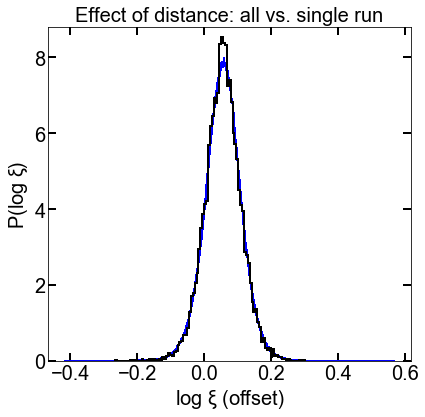

In [46]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(all_alpha_counts))

ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=all_alpha_edges, counts=all_alpha_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=onerun_alpha_edges, counts=onerun_alpha_counts, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Effect of distance: all vs. single run', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/logxi_500runs_ALL.png', dpi=500)

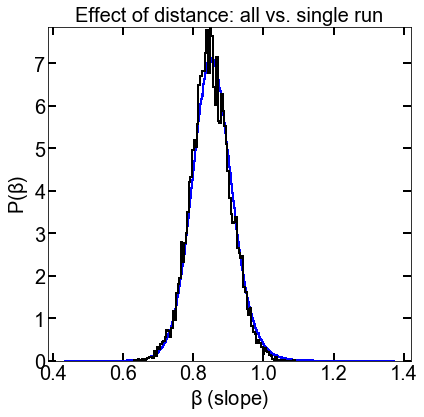

In [47]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(all_beta_counts))

ax.set_xlabel(r'$\beta$ (slope)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=all_beta_edges, counts=all_beta_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=onerun_beta_edges, counts=onerun_beta_counts, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Effect of distance: all vs. single run', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/beta_500runs_ALL.png', dpi=500)

From this, we can see that including distance draws does not make a massive difference. The error on the radio luminosity, especially in radio non-detected observations, are dominant.

### Plotting the output histograms for $\alpha$ and $\beta$: continuing with the mean and 16/84th percentile

In [48]:
print "The fitted values based on the mean of the mean, 16th, and 84th percentile of the 500 runs"
print "------------------------------------------------------------------------------------------"
print 'Alpha =', np.round(np.mean(alpha_mean),3), '+'+str(np.round(np.mean(alpha_84)-np.mean(alpha_mean),3)), str(np.round(np.mean(alpha_16)-np.mean(alpha_mean),3))
print 'Beta =', np.round(np.mean(beta_mean),3), '+'+str(np.round(np.mean(beta_mean)-np.mean(beta_16),3)), str(np.round(np.mean(beta_mean)-np.mean(beta_84),3))
print 'Sigma =', np.round(np.mean(sigma_mean)**0.5,3), '+'+str(np.round(np.mean(np.asarray(sigma_mean)**0.5-np.asarray(sigma_16)**0.5),3)), str(np.round(np.mean(np.asarray(sigma_mean)**0.5-np.asarray(sigma_84)**0.5),3))

The fitted values based on the mean of the mean, 16th, and 84th percentile of the 500 runs
------------------------------------------------------------------------------------------
Alpha = 0.057 +0.051 -0.051
Beta = 0.855 +0.056 -0.056
Sigma = 0.17 +0.05 -0.035


In [49]:
alpha_16_counts, alpha_16_edges = np.histogram(alpha_16, bins=40, density=True)
alpha_50_counts, alpha_50_edges = np.histogram(alpha_50, bins=30, density=True)
alpha_84_counts, alpha_84_edges = np.histogram(alpha_84, bins=40, density=True)
alpha_mode_counts, alpha_mode_edges = np.histogram(alpha_mode, bins=30, density=True)
alpha_mean_counts, alpha_mean_edges = np.histogram(alpha_mean, bins=40, density=True)

beta_16_counts, beta_16_edges = np.histogram(beta_16, bins=40, density=True)
beta_50_counts, beta_50_edges = np.histogram(beta_50, bins=30, density=True)
beta_84_counts, beta_84_edges = np.histogram(beta_84, bins=40, density=True)
beta_mode_counts, beta_mode_edges = np.histogram(beta_mode, bins=30, density=True)
beta_mean_counts, beta_mean_edges = np.histogram(beta_mean, bins=40, density=True)

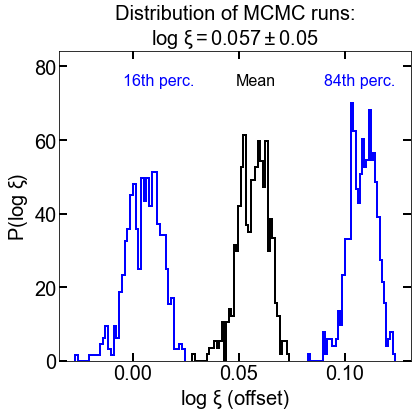

In [50]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.2*max([max(alpha_16_counts),max(alpha_50_counts), max(alpha_84_counts), max(alpha_mean_counts), max(alpha_mode_counts)]))

ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=alpha_16_edges, counts=alpha_16_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=alpha_84_edges, counts=alpha_84_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=alpha_mean_edges, counts=alpha_mean_counts, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Distribution of MCMC runs:'+'\n'+r'log $\xi = 0.057 \pm 0.05$', fontsize=FS)

ax.text(np.mean(alpha_mean)-0.008, 75, 'Mean', fontsize=FS-4)
ax.text(np.mean(alpha_16)-0.01, 75, '16th perc.', fontsize=FS-4, color='b')
ax.text(np.mean(alpha_84)-0.018, 75, '84th perc.', fontsize=FS-4, color='b')

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/logxi_500runs.png', dpi=500)

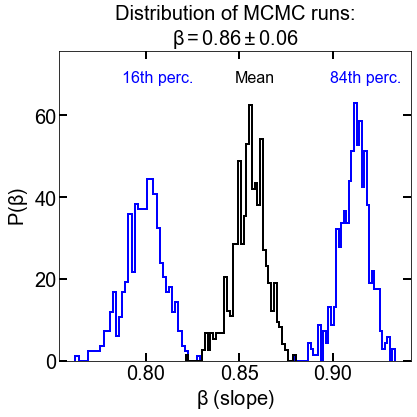

In [51]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.2*max([max(beta_16_counts),max(beta_50_counts), max(beta_84_counts), max(beta_mean_counts), max(beta_mode_counts)]))

ax.set_xlabel(r'$\beta$ (slope)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=beta_16_edges, counts=beta_16_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=beta_84_edges, counts=beta_84_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=beta_mean_edges, counts=beta_mean_counts, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Distribution of MCMC runs:'+'\n'+r'$\beta = 0.86 \pm 0.06$', fontsize=FS)

ax.text(np.mean(beta_mean)-0.008, 68, 'Mean', fontsize=FS-4)
ax.text(np.mean(beta_16)-0.012, 68, '16th perc.', fontsize=FS-4, color='b')
ax.text(np.mean(beta_84)-0.013, 68, '84th perc.', fontsize=FS-4, color='b')

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/beta_500runs.png', dpi=500)

### Plotting the $L_X$ / $L_R$ diagram with the best fit:

In [52]:
# Defining the ngVLA expectations
RMS_ngVLA = 0.23 * u.microJansky
example_distances = np.asarray([1.0, 2.0, 8.0])*u.kpc

Sens_ngVLA = (4.0*np.pi*(3.*RMS_ngVLA)*(6.0 * u.GHz)*(example_distances**2)).to(u.erg/u.s).value

# Define the different markers for the data points, depending on whether they are detections or upper limits:
ULs = np.abs(delta - 1)
Cs = []
MARKERS = []
MEWS = []
SIZES = []
for UL in ULs:
    if UL == 1:
        Cs.append('w')
        MARKERS.append('p')
        MEWS.append(1)
        SIZES.append(7)
    else:
        Cs.append('w') #k
        MARKERS.append('s')
        MEWS.append(1.5)
        SIZES.append(6)

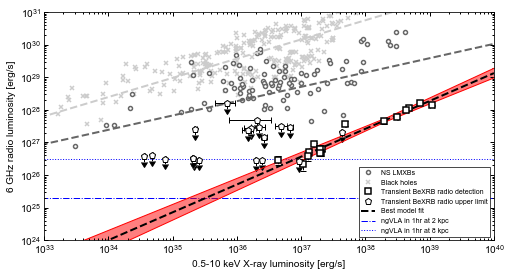

In [53]:
FS  = 10
LS  = 10
MS  = 6
MEW = 2

###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(double_col),cm2inch(10)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=1, length=4, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=2, width=1, axis='both', which='minor', pad=3)

ax.set_xscale('log')
ax.set_yscale('log')
    
ax.set_xlim(1e33, 1e40) #33
ax.set_ylim(1e24, 1e31) #26
ax.set_xticks([1e33, 1e34, 1e35, 1e36, 1e37, 1e38, 1e39, 1e40])
ax.set_xticklabels([r'$10^{33}$', r'$10^{34}$', r'$10^{35}$', r'$10^{36}$', r'$10^{37}$', r'$10^{38}$', r'$10^{39}$', r'$10^{40}$'])
ax.set_yticks([1e24, 1e25, 1e26, 1e27, 1e28, 1e29, 1e30, 1e31])
ax.set_yticklabels([r'$10^{24}$',r'$10^{25}$',r'$10^{26}$',r'$10^{27}$', r'$10^{28}$', r'$10^{29}$', r'$10^{30}$', r'$10^{31}$'])

ax.set_xlabel('0.5-10 keV X-ray luminosity [erg/s]', fontsize=FS)
ax.set_ylabel('6 GHz radio luminosity [erg/s]', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################    
### reading in and plotting the black holes:
###############################################################################################################

ax.plot([],[], 'o', color='w', ms=4, mew=1.5, markeredgecolor='0.4', label=r'NS LMXBs')

BH_lx, BH_lr, BH_det = np.genfromtxt('./Figure6_7/BH_Lx_Lr.txt', dtype='str', delimiter=' ', 
                                              comments='#', unpack=True, usecols=[0,1,2])

BH_lx_plot = []
BH_lr_plot = []
for i in xrange(len(BH_lx)):
    if '1' in BH_det[i]:
        BH_lx_plot.append(float(BH_lx[i]))
        BH_lr_plot.append(float(BH_lr[i]))
        
ax.plot(np.power(10., BH_lx_plot), np.power(10., np.asarray(BH_lr_plot)), 'x', c='0.8', 
        ms=4, mew=1.5, label='Black holes',zorder=0)

###############################################################################################################
### Reading in and plotting the weak B neutron stars:
###############################################################################################################
NS_lx, NS_lr, NS_det, NS_type = np.genfromtxt('./Figure6_7/NS_Lx_Lr.txt', dtype='str', delimiter='\t', 
                                              comments='#', unpack=True, usecols=[1,2,3,4])

NS_lx_plot = []
NS_lr_plot = []
NS_type_plot = []
for i in xrange(len(NS_lr)):
    if NS_det[i] == '1':
        NS_lx_plot.append(float(NS_lx[i]))
        NS_lr_plot.append(float(NS_lr[i]))
        NS_type_plot.append(NS_type[i])
    
CS = {'1':'w', '2':'w', '3':'w', '4':'w'}
MS = {'1':4, '2':4, '3':4, '4':4}
for i in xrange(len(NS_lx_plot)):
    Lx = 10**NS_lx_plot[i]
    
    Lr = (6./5.)*(10**NS_lr_plot[i]) 
    
    ax.plot(Lx, Lr, 'o', color=CS[NS_type_plot[i]], ms=MS[NS_type_plot[i]], mew=1.5, markeredgecolor='0.4',zorder=0)#='0.6')

ax.errorbar(WeakB_lx_plot, WeakB_lr_plot , xerr=WeakB_dlx_plot,
            yerr=WeakB_dlr_plot, fmt='o', color='w', ms=4, mew=1.5, markeredgecolor='0.4',zorder=0)

###############################################################################################################    
### The actual important stuff
###############################################################################################################    

for i in xrange(len(lx)):
    
    ax.errorbar(lx[i], lr[i], xerr=dlx[i], yerr=dlr[i], fmt=MARKERS[i], ms=SIZES[i], uplims=ULs[i], 
                elinewidth=1, capsize=3, color=Cs[i], mec='k', mew=MEWS[i])
    ax.errorbar(lx[i], lr[i], xerr=dlx[i], yerr=dlr[i], fmt=MARKERS[i], color='k', ms=0, uplims=ULs[i], 
                elinewidth=1, capsize=3)
    
ax.plot([], [], 'sw', mec='k', ms=6, mew=1.5, label='Transient BeXRB radio detection')
ax.plot([], [], 'pw', mec='k', ms=7, mew=1., label='Transient BeXRB radio upper limit')

###############################################################################################################    
### Plotting the model
###############################################################################################################    

log_model_axis = np.linspace(30,40,1000,endpoint=True)
model_axis = 10.0**log_model_axis

# Plotting random draws of the fit: those are drawn from the last run of linmix, which is either 
# the test run, or, if done, the 500th run from the full analysis:
case1 = lr0 * ((model_axis/lx0)**(0.855-0.057)) * (10**(0.057+0.052))
case2 = lr0 * ((model_axis/lx0)**(0.855+0.057)) * (10**(0.057-0.052))
case3 = lr0 * ((model_axis/lx0)**(0.855-0.057)) * (10**(0.057-0.052))
case4 = lr0 * ((model_axis/lx0)**(0.855+0.057)) * (10**(0.057+0.052))
maxline = []
minline = []
for i in xrange(len(case1)):
    maxline.append(max(case1[i], case2[i], case3[i], case4[i]))
    minline.append(min(case1[i], case2[i], case3[i], case4[i]))

ax.fill_between(model_axis, minline, maxline, facecolor='r', alpha=0.5)
ax.plot(model_axis, minline, 'r', lw=1)
ax.plot(model_axis, maxline, 'r', lw=1)

# Plotting the best fit values:
model_mean = lr0 * ((model_axis/lx0)**0.855) * (10**(0.057))
ax.plot(model_axis, model_mean, '--', lw=2, color='k', zorder=1, label=r'Best model fit')

model_mean_BHs = (10**28.57)* ((model_axis/(10**36.3))**0.59) * (10**(1.18))
ax.plot(model_axis, model_mean_BHs, '--', lw=2, color='0.80', zorder=1, label=r'')

model_mean_NSLMXBs = (10**28.57)* ((model_axis/(10**36.3))**0.44) * (10**(-0.17))
ax.plot(model_axis, model_mean_NSLMXBs, '--', lw=2, color='0.40', zorder=1, label=r'')

ax.plot([1e1,1e100],[Sens_ngVLA[1],Sens_ngVLA[1]], 'b-.', lw=1, zorder=0, label='ngVLA in 1hr at 2 kpc')
ax.plot([1e1,1e100],[Sens_ngVLA[2],Sens_ngVLA[2]], 'b:', lw=1, zorder=0, label='ngVLA in 1hr at 8 kpc')

###############################################################################################################
### Making the legend:
###############################################################################################################

### The legend:
leg = ax.legend(loc=4, frameon=True, fontsize=7, ncol=1, numpoints=1, fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.7)

plt.tight_layout()
plt.savefig('MCMC_Fitting_and_Figure8/Figure8.png', dpi=500)

## Step 6: repeating the above calculations for the two BeXRBs with detections individually

Here, the structure will be the same as before. Therefore, it is not commented as much as above. Again, we read in the data, fit it once to test the method and get a first idea of the parameters. Then, we perform 500 MCMC runs to test the stability of the fit. We have, again, provided parameter files from a previous run, so that this step can be skipped in order to save time.

In [54]:
# We will use the Gallo et al. 2018 scaling here as well:
lx0 = 2.00e36
lr0 = 3.72e28

In [55]:
FS  = 20
LS  = 20
MS  = 10
MEW = 3

### 6A) First, considering 1A 0535+262

In [56]:
# Defining the data: same method as above, but now only for 1A 0535+262:

lx = []
dlx = []
lr = []
dlr = []
delta = []

for i in xrange(len(lx_05_10_a0535)):
    lx.append(lx_05_10_a0535[i])
    dlx.append(dlx_05_10_a0535[i]) 
    lr.append(lr_a0535[i])
    dlr.append(dlr_a0535[i])
    delta.append(delta_a0535[i])

lx = np.asarray(lx)
dlx = np.asarray(dlx)
lr = np.asarray(lr)
dlr = np.asarray(dlr)
delta = np.asarray(delta)

# Converting to log space:
lx_scaled = lx/lx0
dlx_scaled_p = (lx+dlx)/lx0
dlx_scaled_m = (lx-dlx)/lx0

log_lx_scaled = np.log10(lx_scaled)
log_dlx_scaled_p = np.log10(dlx_scaled_p)
log_dlx_scaled_m = np.log10(dlx_scaled_m)
log_dlx_scaled = (log_dlx_scaled_p - log_dlx_scaled_m)/2.

lr_scaled = lr/lr0
dlr_scaled_p = (lr+dlr)/lr0
dlr_scaled_m = (lr-dlr)/lr0

log_lr_scaled = np.log10(lr_scaled)
log_dlr_scaled_p = np.log10(dlr_scaled_p)
log_dlr_scaled_m = np.log10(dlr_scaled_m)
log_dlr_scaled = (log_dlr_scaled_p - log_dlr_scaled_m)/2.

In [57]:
# First, perform a single fit:
lm_0535 = linmix.LinMix(x=log_lx_scaled, y=log_lr_scaled, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta,K=3)
lm_0535.run_mcmc(miniter=5000,silent=True)

In [58]:
alphas_0535 = []
betas_0535 = []
sigmas_0535 = []
for i in xrange(len(lm_0535.chain)):
    alphas_0535.append(lm_0535.chain[i]['alpha'])
    betas_0535.append(lm_0535.chain[i]['beta'])
    sigmas_0535.append(lm_0535.chain[i]['sigsqr'])
    
alpha_0535_counts, alpha_0535_edges = np.histogram(alphas_0535, bins=100, density=True)
beta_0535_counts, beta_0535_edges = np.histogram(betas_0535, bins=100, density=True)
sigma_0535_counts, sigma_0535_edges = np.histogram(sigmas_0535, bins=500, range=[0,2], density=True)

sixteen=True
eightyfour=True
fifty=True
for X in xrange(len(alpha_0535_counts)):
    if sum(alpha_0535_counts[:X]*(alpha_0535_edges[1:X+1]-alpha_0535_edges[:X])) > 0.16 and sixteen:
        alpha_0535_16 = (alpha_0535_edges[X-1]+alpha_0535_edges[X])/2.
        sixteen = False
    
    if sum(alpha_0535_counts[:X]*(alpha_0535_edges[1:X+1]-alpha_0535_edges[:X])) > 0.50 and fifty:
        alpha_0535_50 = (alpha_0535_edges[X-1]+alpha_0535_edges[X])/2.
        fifty = False
        
    if sum(alpha_0535_counts[:X]*(alpha_0535_edges[1:X+1]-alpha_0535_edges[:X])) > 0.84 and eightyfour:
        alpha_0535_84 = (alpha_0535_edges[X-1]+alpha_0535_edges[X])/2.
        eightyfour = False
        
    if alpha_0535_counts[X] == max(alpha_0535_counts):
        alpha_0535_mode = (alpha_0535_edges[X-1]+alpha_0535_edges[X])/2.
alpha_0535_mean = np.mean(alphas_0535)

sixteen=True
eightyfour=True
fifty=True
for X in xrange(len(beta_0535_counts)):
    if sum(beta_0535_counts[:X]*(beta_0535_edges[1:X+1]-beta_0535_edges[:X])) > 0.16 and sixteen:
        beta_0535_16 = (beta_0535_edges[X-1]+beta_0535_edges[X])/2.
        sixteen = False
    
    if sum(beta_0535_counts[:X]*(beta_0535_edges[1:X+1]-beta_0535_edges[:X])) > 0.50 and fifty:
        beta_0535_50 = (beta_0535_edges[X-1]+beta_0535_edges[X])/2.
        fifty = False
        
    if sum(beta_0535_counts[:X]*(beta_0535_edges[1:X+1]-beta_0535_edges[:X])) > 0.84 and eightyfour:
        beta_0535_84 = (beta_0535_edges[X-1]+beta_0535_edges[X])/2.
        eightyfour = False
        
    if beta_0535_counts[X] == max(beta_0535_counts):
        beta_0535_mode = (beta_0535_edges[X-1]+beta_0535_edges[X])/2.
beta_0535_mean = np.mean(betas_0535)

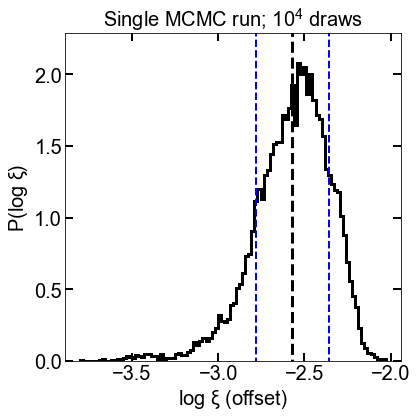

In [59]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(alpha_0535_counts))

ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=alpha_0535_edges, counts=alpha_0535_counts, LW=3, normalized_to_one=False)

ax.plot([alpha_0535_16,alpha_0535_16], [-1,1000], 'b--', lw=2)
ax.plot([alpha_0535_84,alpha_0535_84], [-1,1000], 'b--', lw=2)

#ax.plot([alpha_0535_50,alpha_0535_50], [-1,1000], 'b-', lw=2)
#ax.plot([alpha_0535_mode,alpha_0535_mode], [-1,1000], 'r-', lw=2)
ax.plot([alpha_0535_mean,alpha_0535_mean], [-1,1000], 'k--', lw=3)


ax.set_title('Single MCMC run; $10^4$ draws', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/logxi_singlerun_0535only.png', dpi=500)

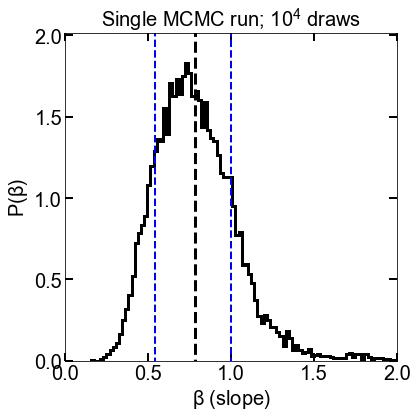

In [60]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(beta_0535_counts))
ax.set_xlim(0.,2.0)

ax.set_xlabel(r'$\beta$ (slope)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=beta_0535_edges, counts=beta_0535_counts, LW=3, normalized_to_one=False)

ax.plot([beta_0535_16,beta_0535_16], [-1,1000], 'b--', lw=2)
ax.plot([beta_0535_84,beta_0535_84], [-1,1000], 'b--', lw=2)
ax.plot([beta_0535_mean,beta_0535_mean], [-1,1000], 'k--', lw=3)

ax.set_title('Single MCMC run; $10^4$ draws', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/beta_0535_singlerun_0535only.png', dpi=500)

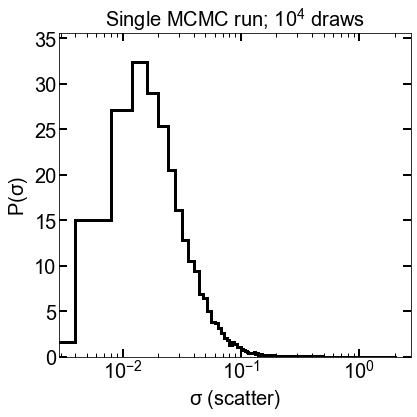

In [61]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_xscale('log')
ax.set_ylim(0, 1.1*max(sigma_0535_counts))

ax.set_xlabel(r'$\sigma$ (scatter)', fontsize=FS)
ax.set_ylabel(r'$P(\sigma)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=sigma_0535_edges, counts=sigma_0535_counts, LW=3, normalized_to_one=False)

ax.set_title('Single MCMC run; $10^4$ draws', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/sigma_0535_singlerun_0535only.png', dpi=500)

Now we can run the MCMC analysis 500 times, or read in the values from the data files:

In [62]:
perform_full_analysis = False

In [63]:
N_runs = 500

In [64]:
if not perform_full_analysis:
    all_alphas_0535 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_alphas_0535.txt')
    all_betas_0535 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_betas_0535.txt')
    all_sigmas_0535 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_sigmas_0535.txt')
    
    alpha_0535_mode = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_0535_mode.txt')
    alpha_0535_16 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_0535_16.txt')
    alpha_0535_84 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_0535_84.txt')
    alpha_0535_50 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_0535_50.txt')
    alpha_0535_mean = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_0535_mean.txt')
    
    beta_0535_mode = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_0535_mode.txt')
    beta_0535_16 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_0535_16.txt')
    beta_0535_84 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_0535_84.txt')
    beta_0535_50 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_0535_50.txt')
    beta_0535_mean = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_0535_mean.txt')
    
    sigma_0535_mode = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_0535_mode.txt')
    sigma_0535_16 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_0535_16.txt')
    sigma_0535_84 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_0535_84.txt')
    sigma_0535_50 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_0535_50.txt')
    sigma_0535_mean = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_0535_mean.txt')

In [65]:
if perform_full_analysis:
    all_alphas_0535 = []
    all_betas_0535 = []
    all_sigmas_0535 = []
    
    alpha_0535_16 = []
    alpha_0535_50 = []
    alpha_0535_84 = []
    alpha_0535_mode = []
    alpha_0535_mean = []

    beta_0535_16 = []
    beta_0535_50 = []
    beta_0535_84 = []
    beta_0535_mode = []
    beta_0535_mean = []

    sigma_0535_16 = []
    sigma_0535_50 = []
    sigma_0535_84 = []
    sigma_0535_mode = []
    sigma_0535_mean = []
    for i in xrange(N_runs):
        clear_output(wait=True)
        display('Iteration '+str(i+1)+' Percentage: '+str((float(i+1)/N_runs)*100.0)+'%')

        X_0535 = np.random.normal(loc=D_a0535.value, scale=dD_a0535.value, size=1)[0]/(D_a0535.value)
        X_array = np.asarray([X_0535]*20)
        d_corr = 2.*np.log10(X_array)
        
        # Run the MCMC
        lm = linmix.LinMix(x=log_lx_scaled+d_corr, y=log_lr_scaled+d_corr, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta,K=3)
        lm.run_mcmc(miniter=5000,silent=True)

        # Extract the fitted parameters
        alphas_0535 = []
        betas_0535 = []
        sigmas_0535 = []
        for i in xrange(len(lm.chain)):
            alphas_0535.append(lm.chain[i]['alpha'])
            betas_0535.append(lm.chain[i]['beta'])
            sigmas_0535.append(lm.chain[i]['sigsqr'])
        all_alphas_0535 = all_alphas_0535 + alphas_0535
        all_betas_0535 = all_betas_0535 + betas_0535
        all_sigmas_0535 = all_sigmas_0535 + sigmas_0535

        # Create histograms
        alpha_0535_counts, alpha_0535_edges = np.histogram(alphas_0535, bins=200, density=True)
        beta_0535_counts, beta_0535_edges = np.histogram(betas_0535, bins=200, density=True)
        sigma_0535_counts, sigma_0535_edges = np.histogram(sigmas_0535, bins=500, range=[0,2], density=True)

        # Determine the mean, mode, median, and 16/84th percentile
        sixteen=True
        eightyfour=True
        fifty=True
        for X in xrange(len(alpha_0535_counts)):
            if sum(alpha_0535_counts[:X]*(alpha_0535_edges[1:X+1]-alpha_0535_edges[:X])) > 0.16 and sixteen:
                alpha_0535_16.append((alpha_0535_edges[X-1]+alpha_0535_edges[X])/2.)
                sixteen = False

            if sum(alpha_0535_counts[:X]*(alpha_0535_edges[1:X+1]-alpha_0535_edges[:X])) > 0.50 and fifty:
                alpha_0535_50.append((alpha_0535_edges[X-1]+alpha_0535_edges[X])/2.)
                fifty = False

            if sum(alpha_0535_counts[:X]*(alpha_0535_edges[1:X+1]-alpha_0535_edges[:X])) > 0.84 and eightyfour:
                alpha_0535_84.append((alpha_0535_edges[X-1]+alpha_0535_edges[X])/2.)
                eightyfour = False

            if alpha_0535_counts[X] == max(alpha_0535_counts):
                alpha_0535_mode.append((alpha_0535_edges[X-1]+alpha_0535_edges[X])/2.)
        alpha_0535_mean.append(np.mean(alphas_0535))

        sixteen=True
        eightyfour=True
        fifty=True
        for X in xrange(len(beta_0535_counts)):
            if sum(beta_0535_counts[:X]*(beta_0535_edges[1:X+1]-beta_0535_edges[:X])) > 0.16 and sixteen:
                beta_0535_16.append((beta_0535_edges[X-1]+beta_0535_edges[X])/2.)
                sixteen = False

            if sum(beta_0535_counts[:X]*(beta_0535_edges[1:X+1]-beta_0535_edges[:X])) > 0.50 and fifty:
                beta_0535_50.append((beta_0535_edges[X-1]+beta_0535_edges[X])/2.)
                fifty = False

            if sum(beta_0535_counts[:X]*(beta_0535_edges[1:X+1]-beta_0535_edges[:X])) > 0.84 and eightyfour:
                beta_0535_84.append((beta_0535_edges[X-1]+beta_0535_edges[X])/2.)
                eightyfour = False

            if beta_0535_counts[X] == max(beta_0535_counts):
                beta_0535_mode.append((beta_0535_edges[X-1]+beta_0535_edges[X])/2.)
        beta_0535_mean.append(np.mean(betas_0535))

        sixteen=True
        eightyfour=True
        fifty=True
        for X in xrange(len(sigma_0535_counts)):
            if sum(sigma_0535_counts[:X]*(sigma_0535_edges[1:X+1]-sigma_0535_edges[:X])) > 0.16 and sixteen:
                sigma_0535_16.append((sigma_0535_edges[X-1]+sigma_0535_edges[X])/2.)
                sixteen = False

            if sum(sigma_0535_counts[:X]*(sigma_0535_edges[1:X+1]-sigma_0535_edges[:X])) > 0.50 and fifty:
                sigma_0535_50.append((sigma_0535_edges[X-1]+sigma_0535_edges[X])/2.)
                fifty = False

            if sum(sigma_0535_counts[:X]*(sigma_0535_edges[1:X+1]-sigma_0535_edges[:X])) > 0.84 and eightyfour:
                sigma_0535_84.append((sigma_0535_edges[X-1]+sigma_0535_edges[X])/2.)
                eightyfour = False

            if sigma_0535_counts[X] == max(sigma_0535_counts):
                sigma_0535_mode.append((sigma_0535_edges[X-1]+sigma_0535_edges[X])/2.)
        sigma_0535_mean.append(np.mean(sigmas_0535))

    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_alphas_0535.txt', all_alphas_0535)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_betas_0535.txt', all_betas_0535)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_sigmas_0535.txt', all_sigmas_0535)
        
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_0535_mode.txt', alpha_0535_mode)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_0535_16.txt', alpha_0535_16)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_0535_84.txt', alpha_0535_84)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_0535_50.txt', alpha_0535_50)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_0535_mean.txt', alpha_0535_mean)
    
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_0535_mode.txt', beta_0535_mode)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_0535_16.txt', beta_0535_16)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_0535_84.txt', beta_0535_84)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_0535_50.txt', beta_0535_50)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_0535_mean.txt', beta_0535_mean)
    
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_0535_mode.txt', sigma_0535_mode)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_0535_16.txt', sigma_0535_16)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_0535_84.txt', sigma_0535_84)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_0535_50.txt', sigma_0535_50)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_0535_mean.txt', sigma_0535_mean)

#### The results using the values from all runs together:

In [66]:
print "The fitted values based on the mean, 16th, and 84th percentile of all values from the 500 runs"
print "----------------------------------------------------------------------------------------------"
print 'Alpha =', np.round(np.mean(all_alphas_0535),3), '+'+str(np.round(np.mean(all_alphas_0535)-np.percentile(all_alphas_0535,16),3)), str(np.round(np.percentile(all_alphas_0535,84)-np.mean(all_alphas_0535),3))
print 'Beta =', np.round(np.mean(all_betas_0535),3), '+'+str(np.round(np.mean(all_betas_0535)-np.percentile(all_betas_0535,16),3)), str(np.round(np.percentile(all_betas_0535,84)-np.mean(all_betas_0535),3))
print 'Sigma =', np.round(np.mean(all_sigmas_0535)**0.5,3), '+'+str(np.round(np.mean(all_sigmas_0535)**0.5-np.percentile(all_sigmas_0535,16)**0.5,3)), str(np.round(np.percentile(all_sigmas_0535,84)**0.5-np.mean(all_sigmas_0535)**0.5,3))

The fitted values based on the mean, 16th, and 84th percentile of all values from the 500 runs
----------------------------------------------------------------------------------------------
Alpha = -2.587 +0.235 0.241
Beta = 0.8 +0.268 0.261
Sigma = 0.184 +0.077 0.045


#### The results using the mean and percentiles per run:

In [67]:
print 'Alpha =', np.round(np.mean(alpha_0535_mean),3), '+'+str(np.round(np.mean(alpha_0535_84)-np.mean(alpha_0535_mean),3)), str(np.round(np.mean(alpha_0535_16)-np.mean(alpha_0535_mean),3))
print 'Beta =', np.round(np.mean(beta_0535_mean),3), '+'+str(np.round(np.mean(beta_0535_mean)-np.mean(beta_0535_16),3)), str(np.round(np.mean(beta_0535_mean)-np.mean(beta_0535_84),3))
print 'Sigma =', np.round(np.mean(sigma_0535_mean)**0.5,3), '+'+str(np.round(np.mean(np.asarray(sigma_0535_mean)**0.5-np.asarray(sigma_0535_16)**0.5),3)), str(np.round(np.mean(np.asarray(sigma_0535_mean)**0.5-np.asarray(sigma_0535_84)**0.5),3))

Alpha = -2.587 +0.237 -0.237
Beta = 0.8 +0.264 -0.263
Sigma = 0.184 +0.082 -0.045


#### Comparing all runs with one run:

In [68]:
all_alpha_counts_0535, all_alpha_edges_0535 = np.histogram(all_alphas_0535, bins=1000, density=True)
all_beta_counts_0535, all_beta_edges_0535 = np.histogram(all_betas_0535, bins=1000, density=True)

# Also loading data for the last of the 500 runs for comparison:
onerun_alpha_counts_0535, onerun_alpha_edges_0535 = np.histogram(alphas_0535, bins=100, density=True)
onerun_beta_counts_0535, onerun_beta_edges_0535 = np.histogram(betas_0535, bins=100, density=True)

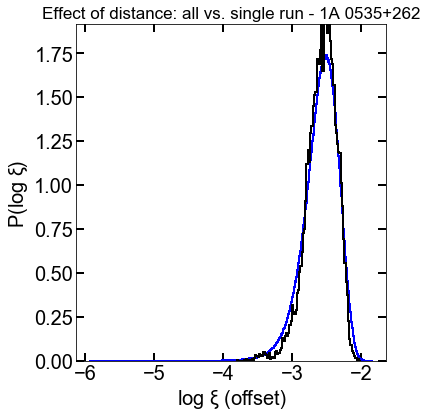

In [69]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(all_alpha_counts_0535))

ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=all_alpha_edges_0535, counts=all_alpha_counts_0535, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=onerun_alpha_edges_0535, counts=onerun_alpha_counts_0535, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Effect of distance: all vs. single run - 1A 0535+262', fontsize=FS-3)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/logxi_500runs_0535only_ALL.png', dpi=500)

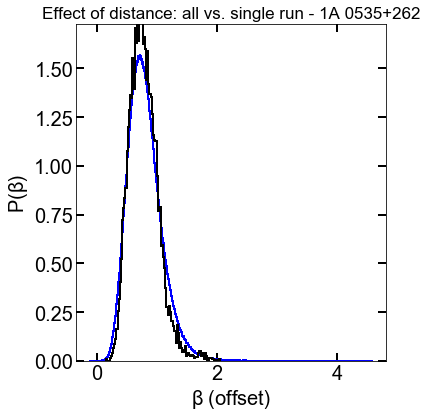

In [70]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(all_beta_counts_0535))

ax.set_xlabel(r'$\beta$ (offset)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=all_beta_edges_0535, counts=all_beta_counts_0535, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=onerun_beta_edges_0535, counts=onerun_beta_counts_0535, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Effect of distance: all vs. single run - 1A 0535+262', fontsize=FS-3)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/beta_500runs_0535only_ALL.png', dpi=500)

#### Plotting histograms of mean and 16/84th percentiles.

In [71]:
alpha_0535_16_counts, alpha_0535_16_edges = np.histogram(alpha_0535_16, bins=40, density=True)
alpha_0535_50_counts, alpha_0535_50_edges = np.histogram(alpha_0535_50, bins=30, density=True)
alpha_0535_84_counts, alpha_0535_84_edges = np.histogram(alpha_0535_84, bins=40, density=True)
alpha_0535_mode_counts, alpha_0535_mode_edges = np.histogram(alpha_0535_mode, bins=30, density=True)
alpha_0535_mean_counts, alpha_0535_mean_edges = np.histogram(alpha_0535_mean, bins=40, density=True)

beta_0535_16_counts, beta_0535_16_edges = np.histogram(beta_0535_16, bins=40, density=True)
beta_0535_50_counts, beta_0535_50_edges = np.histogram(beta_0535_50, bins=30, density=True)
beta_0535_84_counts, beta_0535_84_edges = np.histogram(beta_0535_84, bins=40, density=True)
beta_0535_mode_counts, beta_0535_mode_edges = np.histogram(beta_0535_mode, bins=30, density=True)
beta_0535_mean_counts, beta_0535_mean_edges = np.histogram(beta_0535_mean, bins=40, density=True)

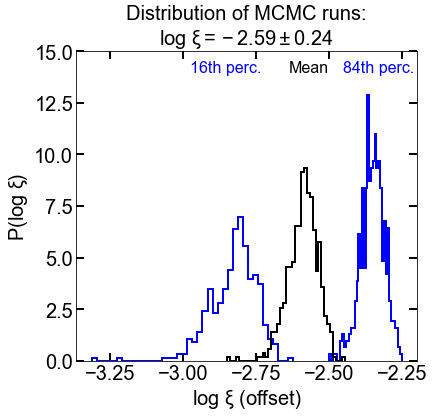

In [72]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 15)

ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=alpha_0535_16_edges, counts=alpha_0535_16_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=alpha_0535_84_edges, counts=alpha_0535_84_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=alpha_0535_mean_edges, counts=alpha_0535_mean_counts, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Distribution of MCMC runs:'+'\n'+r'log $\xi = -2.59 \pm 0.24$', fontsize=FS)

ax.text(np.mean(alpha_0535_mean)-0.05, 14, 'Mean', fontsize=FS-4)
ax.text(np.mean(alpha_0535_16)-0.15, 14, '16th perc.', fontsize=FS-4, color='b')
ax.text(np.mean(alpha_0535_84)-0.1, 14, '84th perc.', fontsize=FS-4, color='b')


###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/logxi_500runs_0535only.png', dpi=500)

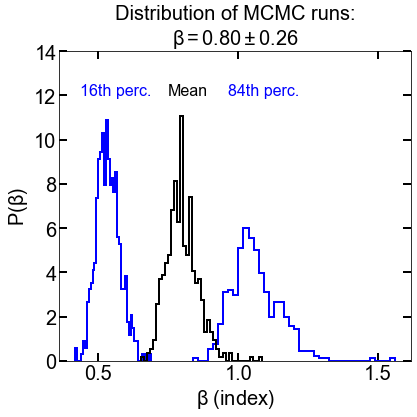

In [73]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 14)

ax.set_xlabel(r'$\beta$ (index)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=beta_0535_16_edges, counts=beta_0535_16_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=beta_0535_84_edges, counts=beta_0535_84_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=beta_0535_mean_edges, counts=beta_0535_mean_counts, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Distribution of MCMC runs:'+'\n'+r'$\beta = 0.80 \pm 0.26$', fontsize=FS)

ax.text(np.mean(beta_0535_mean)-0.05, 12, 'Mean', fontsize=FS-4)
ax.text(np.mean(beta_0535_16)-0.1, 12, '16th perc.', fontsize=FS-4, color='b')
ax.text(np.mean(beta_0535_84)-0.1, 12, '84th perc.', fontsize=FS-4, color='b')

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/beta_500runs_0535only.png', dpi=500)

### 6B) Secondly, considering Swift J0243.6+6124

In [74]:
lx = []
dlx = []
lr = []
dlr = []
delta = []

for i in xrange(len(lx_05_10_SwJ0243)):
    lx.append(lx_05_10_SwJ0243[i])
    dlx.append(dlx_05_10_SwJ0243[i]) 
    lr.append(lr_SwJ0243[i])
    dlr.append(dlr_SwJ0243[i])
    delta.append(delta_SwJ0243[i])

lx = np.asarray(lx)
dlx = np.asarray(dlx)
lr = np.asarray(lr)
dlr = np.asarray(dlr)
delta = np.asarray(delta)

# Converting to log space:
lx_scaled = lx/lx0
dlx_scaled_p = (lx+dlx)/lx0
dlx_scaled_m = (lx-dlx)/lx0

log_lx_scaled = np.log10(lx_scaled)
log_dlx_scaled_p = np.log10(dlx_scaled_p)
log_dlx_scaled_m = np.log10(dlx_scaled_m)
log_dlx_scaled = (log_dlx_scaled_p - log_dlx_scaled_m)/2.

lr_scaled = lr/lr0
dlr_scaled_p = (lr+dlr)/lr0
dlr_scaled_m = (lr-dlr)/lr0

log_lr_scaled = np.log10(lr_scaled)
log_dlr_scaled_p = np.log10(dlr_scaled_p)
log_dlr_scaled_m = np.log10(dlr_scaled_m)
log_dlr_scaled = (log_dlr_scaled_p - log_dlr_scaled_m)/2.

In [78]:
lm_SwJ0243 = linmix.LinMix(x=log_lx_scaled, y=log_lr_scaled, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta,K=3)
lm_SwJ0243.run_mcmc(miniter=5000,silent=True)

In [79]:
alphas_SwJ0243 = []
betas_SwJ0243 = []
sigmas_SwJ0243 = []
for i in xrange(len(lm_SwJ0243.chain)):
    alphas_SwJ0243.append(lm_SwJ0243.chain[i]['alpha'])
    betas_SwJ0243.append(lm_SwJ0243.chain[i]['beta'])
    sigmas_SwJ0243.append(lm_SwJ0243.chain[i]['sigsqr'])

alpha_SwJ0243_counts, alpha_SwJ0243_edges = np.histogram(alphas_SwJ0243, bins=100, density=True)
beta_SwJ0243_counts, beta_SwJ0243_edges = np.histogram(betas_SwJ0243, bins=100, density=True)
sigma_SwJ0243_counts, sigma_SwJ0243_edges = np.histogram(sigmas_SwJ0243, bins=500, range=[0,2], density=True)

sixteen=True
eightyfour=True
fifty=True
for X in xrange(len(alpha_SwJ0243_counts)):
    if sum(alpha_SwJ0243_counts[:X]*(alpha_SwJ0243_edges[1:X+1]-alpha_SwJ0243_edges[:X])) > 0.16 and sixteen:
        alpha_SwJ0243_16 = (alpha_SwJ0243_edges[X-1]+alpha_SwJ0243_edges[X])/2.
        sixteen = False
    
    if sum(alpha_SwJ0243_counts[:X]*(alpha_SwJ0243_edges[1:X+1]-alpha_SwJ0243_edges[:X])) > 0.50 and fifty:
        alpha_SwJ0243_50 = (alpha_SwJ0243_edges[X-1]+alpha_SwJ0243_edges[X])/2.
        fifty = False
        
    if sum(alpha_SwJ0243_counts[:X]*(alpha_SwJ0243_edges[1:X+1]-alpha_SwJ0243_edges[:X])) > 0.84 and eightyfour:
        alpha_SwJ0243_84 = (alpha_SwJ0243_edges[X-1]+alpha_SwJ0243_edges[X])/2.
        eightyfour = False
        
    if alpha_SwJ0243_counts[X] == max(alpha_SwJ0243_counts):
        alpha_SwJ0243_mode = (alpha_SwJ0243_edges[X-1]+alpha_SwJ0243_edges[X])/2.
alpha_SwJ0243_mean = np.mean(alphas_SwJ0243)

sixteen=True
eightyfour=True
fifty=True
for X in xrange(len(beta_SwJ0243_counts)):
    if sum(beta_SwJ0243_counts[:X]*(beta_SwJ0243_edges[1:X+1]-beta_SwJ0243_edges[:X])) > 0.16 and sixteen:
        beta_SwJ0243_16 = (beta_SwJ0243_edges[X-1]+beta_SwJ0243_edges[X])/2.
        sixteen = False
    
    if sum(beta_SwJ0243_counts[:X]*(beta_SwJ0243_edges[1:X+1]-beta_SwJ0243_edges[:X])) > 0.50 and fifty:
        beta_SwJ0243_50 = (beta_SwJ0243_edges[X-1]+beta_SwJ0243_edges[X])/2.
        fifty = False
        
    if sum(beta_SwJ0243_counts[:X]*(beta_SwJ0243_edges[1:X+1]-beta_SwJ0243_edges[:X])) > 0.84 and eightyfour:
        beta_SwJ0243_84 = (beta_SwJ0243_edges[X-1]+beta_SwJ0243_edges[X])/2.
        eightyfour = False
        
    if beta_SwJ0243_counts[X] == max(beta_SwJ0243_counts):
        beta_SwJ0243_mode = (beta_SwJ0243_edges[X-1]+beta_SwJ0243_edges[X])/2.
beta_SwJ0243_mean = np.mean(betas_SwJ0243)

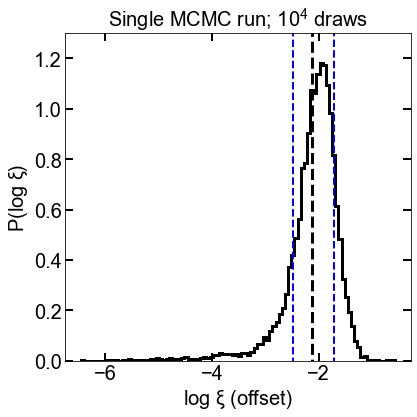

In [80]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(alpha_SwJ0243_counts))

ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=alpha_SwJ0243_edges, counts=alpha_SwJ0243_counts, LW=3, normalized_to_one=False)

ax.plot([alpha_SwJ0243_16,alpha_SwJ0243_16], [-1,1000], 'b--', lw=2)
ax.plot([alpha_SwJ0243_84,alpha_SwJ0243_84], [-1,1000], 'b--', lw=2)

ax.plot([alpha_SwJ0243_mean,alpha_SwJ0243_mean], [-1,1000], 'k--', lw=3)

ax.set_title('Single MCMC run; $10^4$ draws', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/logxi_singlerun_SwJ0243only.png', dpi=500)

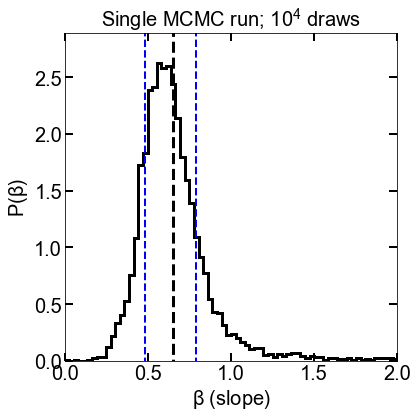

In [81]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(beta_SwJ0243_counts))
ax.set_xlim(0.,2.0)

ax.set_xlabel(r'$\beta$ (slope)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=beta_SwJ0243_edges, counts=beta_SwJ0243_counts, LW=3, normalized_to_one=False)

ax.plot([beta_SwJ0243_16,beta_SwJ0243_16], [-1,1000], 'b--', lw=2)
ax.plot([beta_SwJ0243_84,beta_SwJ0243_84], [-1,1000], 'b--', lw=2)
ax.plot([beta_SwJ0243_mean,beta_SwJ0243_mean], [-1,1000], 'k--', lw=3)

ax.set_title('Single MCMC run; $10^4$ draws', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/beta_SwJ0243_singlerun_SwJ0243only.png', dpi=500)

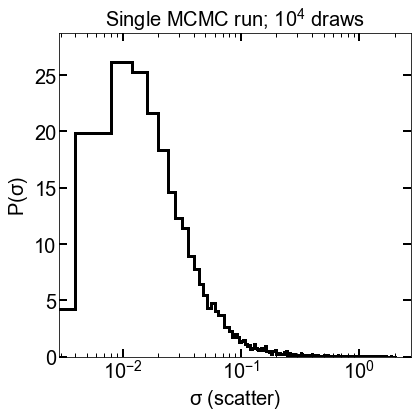

In [82]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_xscale('log')
ax.set_ylim(0, 1.1*max(sigma_SwJ0243_counts))

ax.set_xlabel(r'$\sigma$ (scatter)', fontsize=FS)
ax.set_ylabel(r'$P(\sigma)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=sigma_SwJ0243_edges, counts=sigma_SwJ0243_counts, LW=3, normalized_to_one=False)

ax.set_title('Single MCMC run; $10^4$ draws', fontsize=FS)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/sigma_SwJ0243_singlerun_SwJ0243only.png', dpi=500)

Now we can run the MCMC analysis 500 times, or read in the values from the data files:

In [83]:
perform_full_analysis = False

In [84]:
N_runs = 500

In [85]:
if not perform_full_analysis:
    all_alphas_SwJ0243 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_alphas_SwJ0243.txt')
    all_betas_SwJ0243 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_betas_SwJ0243.txt')
    all_sigmas_SwJ0243 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_sigmas_SwJ0243.txt')
    
    alpha_SwJ0243_mode = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_SwJ0243_mode.txt')
    alpha_SwJ0243_16 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_SwJ0243_16.txt')
    alpha_SwJ0243_84 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_SwJ0243_84.txt')
    alpha_SwJ0243_50 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_SwJ0243_50.txt')
    alpha_SwJ0243_mean = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_SwJ0243_mean.txt')
    
    beta_SwJ0243_mode = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_SwJ0243_mode.txt')
    beta_SwJ0243_16 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_SwJ0243_16.txt')
    beta_SwJ0243_84 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_SwJ0243_84.txt')
    beta_SwJ0243_50 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_SwJ0243_50.txt')
    beta_SwJ0243_mean = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_SwJ0243_mean.txt')
    
    sigma_SwJ0243_mode = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_SwJ0243_mode.txt')
    sigma_SwJ0243_16 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_SwJ0243_16.txt')
    sigma_SwJ0243_84 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_SwJ0243_84.txt')
    sigma_SwJ0243_50 = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_SwJ0243_50.txt')
    sigma_SwJ0243_mean = np.loadtxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_SwJ0243_mean.txt')

In [86]:
if perform_full_analysis:
    all_alphas_SwJ0243 = []
    all_betas_SwJ0243 = []
    all_sigmas_SwJ0243 = []
    
    alpha_SwJ0243_16 = []
    alpha_SwJ0243_50 = []
    alpha_SwJ0243_84 = []
    alpha_SwJ0243_mode = []
    alpha_SwJ0243_mean = []

    beta_SwJ0243_16 = []
    beta_SwJ0243_50 = []
    beta_SwJ0243_84 = []
    beta_SwJ0243_mode = []
    beta_SwJ0243_mean = []

    sigma_SwJ0243_16 = []
    sigma_SwJ0243_50 = []
    sigma_SwJ0243_84 = []
    sigma_SwJ0243_mode = []
    sigma_SwJ0243_mean = []
    for i in xrange(N_runs):
        clear_output(wait=True)
        display('Iteration '+str(i+1)+' Percentage: '+str((float(i+1)/N_runs)*100.0)+'%')

        X_SwJ0243 = np.random.normal(loc=D_SwJ0243.value, scale=dD_SwJ0243.value, size=1)[0]/(D_SwJ0243.value)
        X_array = np.asarray([X_SwJ0243]*11)
        d_corr = 2.*np.log10(X_array)
        
        # Run the MCMC
        lm = linmix.LinMix(x=log_lx_scaled+d_corr, y=log_lr_scaled+d_corr, xsig=log_dlx_scaled, ysig=log_dlr_scaled, delta=delta,K=3)
        lm.run_mcmc(miniter=5000,silent=True)

        # Extract the fitted parameters
        alphas_SwJ0243 = []
        betas_SwJ0243 = []
        sigmas_SwJ0243 = []
        for i in xrange(len(lm.chain)):
            alphas_SwJ0243.append(lm.chain[i]['alpha'])
            betas_SwJ0243.append(lm.chain[i]['beta'])
            sigmas_SwJ0243.append(lm.chain[i]['sigsqr'])
        all_alphas_SwJ0243 = all_alphas_SwJ0243 + alphas_SwJ0243
        all_betas_SwJ0243 = all_betas_SwJ0243 + betas_SwJ0243
        all_sigmas_SwJ0243 = all_sigmas_SwJ0243 + sigmas_SwJ0243

        # Create histograms
        alpha_SwJ0243_counts, alpha_SwJ0243_edges = np.histogram(alphas_SwJ0243, bins=200, density=True)
        beta_SwJ0243_counts, beta_SwJ0243_edges = np.histogram(betas_SwJ0243, bins=200, density=True)
        sigma_SwJ0243_counts, sigma_SwJ0243_edges = np.histogram(sigmas_SwJ0243, bins=500, range=[0,2], density=True)

        # Determine the mean, mode, median, and 16/84th percentile
        sixteen=True
        eightyfour=True
        fifty=True
        for X in xrange(len(alpha_SwJ0243_counts)):
            if sum(alpha_SwJ0243_counts[:X]*(alpha_SwJ0243_edges[1:X+1]-alpha_SwJ0243_edges[:X])) > 0.16 and sixteen:
                alpha_SwJ0243_16.append((alpha_SwJ0243_edges[X-1]+alpha_SwJ0243_edges[X])/2.)
                sixteen = False

            if sum(alpha_SwJ0243_counts[:X]*(alpha_SwJ0243_edges[1:X+1]-alpha_SwJ0243_edges[:X])) > 0.50 and fifty:
                alpha_SwJ0243_50.append((alpha_SwJ0243_edges[X-1]+alpha_SwJ0243_edges[X])/2.)
                fifty = False

            if sum(alpha_SwJ0243_counts[:X]*(alpha_SwJ0243_edges[1:X+1]-alpha_SwJ0243_edges[:X])) > 0.84 and eightyfour:
                alpha_SwJ0243_84.append((alpha_SwJ0243_edges[X-1]+alpha_SwJ0243_edges[X])/2.)
                eightyfour = False

            if alpha_SwJ0243_counts[X] == max(alpha_SwJ0243_counts):
                alpha_SwJ0243_mode.append((alpha_SwJ0243_edges[X-1]+alpha_SwJ0243_edges[X])/2.)
        alpha_SwJ0243_mean.append(np.mean(alphas_SwJ0243))

        sixteen=True
        eightyfour=True
        fifty=True
        for X in xrange(len(beta_SwJ0243_counts)):
            if sum(beta_SwJ0243_counts[:X]*(beta_SwJ0243_edges[1:X+1]-beta_SwJ0243_edges[:X])) > 0.16 and sixteen:
                beta_SwJ0243_16.append((beta_SwJ0243_edges[X-1]+beta_SwJ0243_edges[X])/2.)
                sixteen = False

            if sum(beta_SwJ0243_counts[:X]*(beta_SwJ0243_edges[1:X+1]-beta_SwJ0243_edges[:X])) > 0.50 and fifty:
                beta_SwJ0243_50.append((beta_SwJ0243_edges[X-1]+beta_SwJ0243_edges[X])/2.)
                fifty = False

            if sum(beta_SwJ0243_counts[:X]*(beta_SwJ0243_edges[1:X+1]-beta_SwJ0243_edges[:X])) > 0.84 and eightyfour:
                beta_SwJ0243_84.append((beta_SwJ0243_edges[X-1]+beta_SwJ0243_edges[X])/2.)
                eightyfour = False

            if beta_SwJ0243_counts[X] == max(beta_SwJ0243_counts):
                beta_SwJ0243_mode.append((beta_SwJ0243_edges[X-1]+beta_SwJ0243_edges[X])/2.)
        beta_SwJ0243_mean.append(np.mean(betas_SwJ0243))

        sixteen=True
        eightyfour=True
        fifty=True
        for X in xrange(len(sigma_SwJ0243_counts)):
            if sum(sigma_SwJ0243_counts[:X]*(sigma_SwJ0243_edges[1:X+1]-sigma_SwJ0243_edges[:X])) > 0.16 and sixteen:
                sigma_SwJ0243_16.append((sigma_SwJ0243_edges[X-1]+sigma_SwJ0243_edges[X])/2.)
                sixteen = False

            if sum(sigma_SwJ0243_counts[:X]*(sigma_SwJ0243_edges[1:X+1]-sigma_SwJ0243_edges[:X])) > 0.50 and fifty:
                sigma_SwJ0243_50.append((sigma_SwJ0243_edges[X-1]+sigma_SwJ0243_edges[X])/2.)
                fifty = False

            if sum(sigma_SwJ0243_counts[:X]*(sigma_SwJ0243_edges[1:X+1]-sigma_SwJ0243_edges[:X])) > 0.84 and eightyfour:
                sigma_SwJ0243_84.append((sigma_SwJ0243_edges[X-1]+sigma_SwJ0243_edges[X])/2.)
                eightyfour = False

            if sigma_SwJ0243_counts[X] == max(sigma_SwJ0243_counts):
                sigma_SwJ0243_mode.append((sigma_SwJ0243_edges[X-1]+sigma_SwJ0243_edges[X])/2.)
        sigma_SwJ0243_mean.append(np.mean(sigmas_SwJ0243))
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_alphas_SwJ0243.txt', all_alphas_SwJ0243)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_betas_SwJ0243.txt', all_betas_SwJ0243)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/all_sigmas_SwJ0243.txt', all_sigmas_SwJ0243)
             
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_SwJ0243_mode.txt', alpha_SwJ0243_mode)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_SwJ0243_16.txt', alpha_SwJ0243_16)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_SwJ0243_84.txt', alpha_SwJ0243_84)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_SwJ0243_50.txt', alpha_SwJ0243_50)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/alpha_SwJ0243_mean.txt', alpha_SwJ0243_mean)
    
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_SwJ0243_mode.txt', beta_SwJ0243_mode)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_SwJ0243_16.txt', beta_SwJ0243_16)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_SwJ0243_84.txt', beta_SwJ0243_84)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_SwJ0243_50.txt', beta_SwJ0243_50)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/beta_SwJ0243_mean.txt', beta_SwJ0243_mean)
    
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_SwJ0243_mode.txt', sigma_SwJ0243_mode)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_SwJ0243_16.txt', sigma_SwJ0243_16)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_SwJ0243_84.txt', sigma_SwJ0243_84)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_SwJ0243_50.txt', sigma_SwJ0243_50)
    np.savetxt('./MCMC_Fitting_and_Figure8/MCMC_parfiles/sigma_SwJ0243_mean.txt', sigma_SwJ0243_mean)

#### The results using the values from all runs together:

In [87]:
print "The fitted values based on the mean, 16th, and 84th percentile of all values from the 500 runs"
print "----------------------------------------------------------------------------------------------"
print 'Alpha =', np.round(np.mean(all_alphas_SwJ0243),3), '+'+str(np.round(np.mean(all_alphas_SwJ0243)-np.percentile(all_alphas_SwJ0243,16),3)), str(np.round(np.percentile(all_alphas_SwJ0243,84)-np.mean(all_alphas_SwJ0243),3))
print 'Beta =', np.round(np.mean(all_betas_SwJ0243),3), '+'+str(np.round(np.mean(all_betas_SwJ0243)-np.percentile(all_betas_SwJ0243,16),3)), str(np.round(np.percentile(all_betas_SwJ0243,84)-np.mean(all_betas_SwJ0243),3))
print 'Sigma =', np.round(np.mean(all_sigmas_SwJ0243)**0.5,3), '+'+str(np.round(np.mean(all_sigmas_SwJ0243)**0.5-np.percentile(all_sigmas_SwJ0243,16)**0.5,3)), str(np.round(np.percentile(all_sigmas_SwJ0243,84)**0.5-np.mean(all_sigmas_SwJ0243)**0.5,3))

The fitted values based on the mean, 16th, and 84th percentile of all values from the 500 runs
----------------------------------------------------------------------------------------------
Alpha = -2.125 +0.322 0.376
Beta = 0.653 +0.165 0.142
Sigma = 0.262 +0.161 0.019


#### The results using the mean and percentiles per run:

In [88]:
print 'Alpha =', np.round(np.mean(alpha_SwJ0243_mean),3), '+'+str(np.round(np.mean(alpha_SwJ0243_84)-np.mean(alpha_SwJ0243_mean),3)), str(np.round(np.mean(alpha_SwJ0243_16)-np.mean(alpha_SwJ0243_mean),3))
print 'Beta =', np.round(np.mean(beta_SwJ0243_mean),3), '+'+str(np.round(np.mean(beta_SwJ0243_mean)-np.mean(beta_SwJ0243_16),3)), str(np.round(np.mean(beta_SwJ0243_mean)-np.mean(beta_SwJ0243_84),3))
print 'Sigma =', np.round(np.mean(sigma_SwJ0243_mean)**0.5,3), '+'+str(np.round(np.mean(np.asarray(sigma_SwJ0243_mean)**0.5-np.asarray(sigma_SwJ0243_16)**0.5),3)), str(np.round(np.mean(np.asarray(sigma_SwJ0243_mean)**0.5-np.asarray(sigma_SwJ0243_84)**0.5),3))

Alpha = -2.119 +0.368 -0.333
Beta = 0.651 +0.163 -0.147
Sigma = 0.253 +0.142 -0.038


#### Comparing all runs with one run:

In [89]:
all_alpha_counts_SwJ0243, all_alpha_edges_SwJ0243 = np.histogram(all_alphas_SwJ0243, bins=1000, density=True)
all_beta_counts_SwJ0243, all_beta_edges_SwJ0243 = np.histogram(all_betas_SwJ0243, bins=1000, density=True)

# Also loading data for the last of the 500 runs for comparison:
onerun_alpha_counts_SwJ0243, onerun_alpha_edges_SwJ0243 = np.histogram(alphas_SwJ0243, bins=100, density=True)
onerun_beta_counts_SwJ0243, onerun_beta_edges_SwJ0243 = np.histogram(betas_SwJ0243, bins=100, density=True)

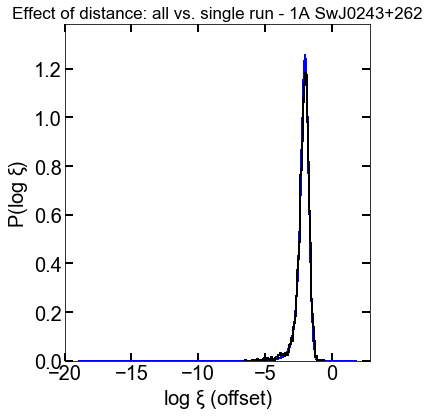

In [90]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(all_alpha_counts_SwJ0243))

ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=all_alpha_edges_SwJ0243, counts=all_alpha_counts_SwJ0243, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=onerun_alpha_edges_SwJ0243, counts=onerun_alpha_counts_SwJ0243, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Effect of distance: all vs. single run - 1A SwJ0243+262', fontsize=FS-3)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/logxi_500runs_SwJ0243only_ALL.png', dpi=500)

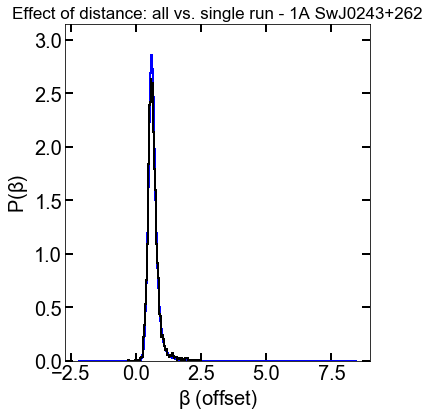

In [91]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 1.1*max(all_beta_counts_SwJ0243))

ax.set_xlabel(r'$\beta$ (offset)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=all_beta_edges_SwJ0243, counts=all_beta_counts_SwJ0243, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=onerun_beta_edges_SwJ0243, counts=onerun_beta_counts_SwJ0243, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Effect of distance: all vs. single run - 1A SwJ0243+262', fontsize=FS-3)

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/beta_500runs_SwJ0243only_ALL.png', dpi=500)

#### Plotting histograms of mean and 16/84th percentiles.

In [92]:
alpha_SwJ0243_16_counts, alpha_SwJ0243_16_edges = np.histogram(alpha_SwJ0243_16, bins=40, density=True, range=[-2.8,-2.2])
alpha_SwJ0243_50_counts, alpha_SwJ0243_50_edges = np.histogram(alpha_SwJ0243_50, bins=30, density=True, range=[-3,-1.5])
alpha_SwJ0243_84_counts, alpha_SwJ0243_84_edges = np.histogram(alpha_SwJ0243_84, bins=40, density=True, range=[-2,-1.5])
alpha_SwJ0243_mode_counts, alpha_SwJ0243_mode_edges = np.histogram(alpha_SwJ0243_mode, bins=30, density=True, range=[-3,-1.5])
alpha_SwJ0243_mean_counts, alpha_SwJ0243_mean_edges = np.histogram(alpha_SwJ0243_mean, bins=40, density=True, range=[-2.4,-1.8])

beta_SwJ0243_16_counts, beta_SwJ0243_16_edges = np.histogram(beta_SwJ0243_16, bins=40, density=True, range=[0.4,0.55])
beta_SwJ0243_50_counts, beta_SwJ0243_50_edges = np.histogram(beta_SwJ0243_50, bins=30, density=True)
beta_SwJ0243_84_counts, beta_SwJ0243_84_edges = np.histogram(beta_SwJ0243_84, bins=40, density=True, range=[0.7,1.0])
beta_SwJ0243_mode_counts, beta_SwJ0243_mode_edges = np.histogram(beta_SwJ0243_mode, bins=30, density=True)
beta_SwJ0243_mean_counts, beta_SwJ0243_mean_edges = np.histogram(beta_SwJ0243_mean, bins=40, density=True, range=[0.6,0.8])

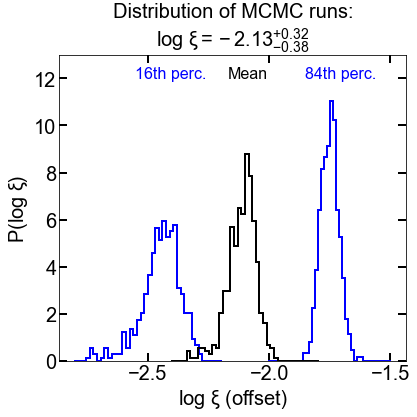

In [93]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 13)

ax.set_xlabel(r'log $\xi$ (offset)', fontsize=FS)
ax.set_ylabel(r'P(log $\xi$)', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=alpha_SwJ0243_16_edges, counts=alpha_SwJ0243_16_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=alpha_SwJ0243_84_edges, counts=alpha_SwJ0243_84_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=alpha_SwJ0243_mean_edges, counts=alpha_SwJ0243_mean_counts, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Distribution of MCMC runs:'+'\n'+r'log $\xi = -2.13^{+0.32}_{-0.38}$', fontsize=FS)

ax.text(np.mean(alpha_SwJ0243_mean)-0.05, 12, 'Mean', fontsize=FS-4)
ax.text(np.mean(alpha_SwJ0243_16)-0.1, 12, '16th perc.', fontsize=FS-4, color='b')
ax.text(np.mean(alpha_SwJ0243_84)-0.1, 12, '84th perc.', fontsize=FS-4, color='b')


###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/logxi_500runs_SwJ0243only.png', dpi=500)

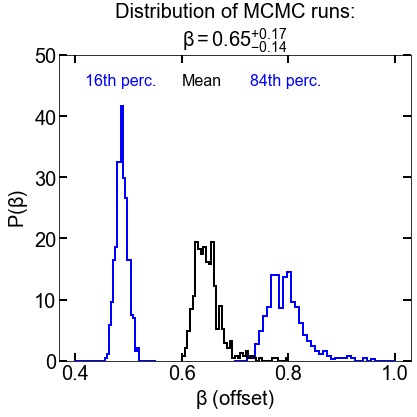

In [94]:
###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(15.),cm2inch(15)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=4, width=1, axis='both', which='minor', pad=3)
    
ax.set_ylim(0, 50)
ax.set_xlabel(r'$\beta$ (offset)', fontsize=FS)
ax.set_ylabel(r'$P(\beta)$', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################
### Plotting histograms
###############################################################################################################

hist_plotter(ax=ax, edges=beta_SwJ0243_16_edges, counts=beta_SwJ0243_16_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=beta_SwJ0243_84_edges, counts=beta_SwJ0243_84_counts, LW=2, normalized_to_one=False, C='b')
hist_plotter(ax=ax, edges=beta_SwJ0243_mean_edges, counts=beta_SwJ0243_mean_counts, LW=2, normalized_to_one=False, C='k')

ax.set_title(r'Distribution of MCMC runs:'+'\n'+r'$\beta = 0.65^{+0.17}_{-0.14}$', fontsize=FS)

ax.text(np.mean(beta_SwJ0243_mean)-0.05, 45, 'Mean', fontsize=FS-4)
ax.text(np.mean(beta_SwJ0243_16)-0.07, 45, '16th perc.', fontsize=FS-4, color='b')
ax.text(np.mean(beta_SwJ0243_84)-0.07, 45, '84th perc.', fontsize=FS-4, color='b')

###############################################################################################################
plt.tight_layout()
plt.savefig('./MCMC_Fitting_and_Figure8/beta_500runs_SwJ0243only.png', dpi=500)

### 6C) Finally, plotting the two sources and their individual fits in the $L_X/L_R$ diagram

### Note: this Figure is not part of the paper but is included for checks of the methods

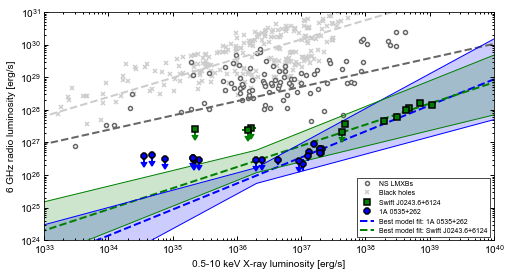

In [95]:
FS  = 10
LS  = 10
MS  = 6
MEW = 2

###############################################################################################################
### Setting up the figure:   
###############################################################################################################
fig = plt.figure(figsize=(cm2inch(double_col),cm2inch(10)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=1, length=4, axis='both', which='major', pad=3)
ax.tick_params(labelsize=LS, length=2, width=1, axis='both', which='minor', pad=3)

ax.set_xscale('log')
ax.set_yscale('log')
    
ax.set_xlim(1e33, 1e40) #33
ax.set_ylim(1e24, 1e31) #26
ax.set_xticks([1e33, 1e34, 1e35, 1e36, 1e37, 1e38, 1e39, 1e40])
ax.set_xticklabels([r'$10^{33}$', r'$10^{34}$', r'$10^{35}$', r'$10^{36}$', r'$10^{37}$', r'$10^{38}$', r'$10^{39}$', r'$10^{40}$'])
ax.set_yticks([1e24, 1e25, 1e26, 1e27, 1e28, 1e29, 1e30, 1e31])
ax.set_yticklabels([r'$10^{24}$',r'$10^{25}$',r'$10^{26}$',r'$10^{27}$', r'$10^{28}$', r'$10^{29}$', r'$10^{30}$', r'$10^{31}$'])

ax.set_xlabel('0.5-10 keV X-ray luminosity [erg/s]', fontsize=FS)
ax.set_ylabel('6 GHz radio luminosity [erg/s]', fontsize=FS)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

###############################################################################################################    
### reading in and plotting the black holes:
###############################################################################################################

ax.plot([],[], 'o', color='w', ms=4, mew=1.5, markeredgecolor='0.4', label=r'NS LMXBs')

BH_lx, BH_lr, BH_det = np.genfromtxt('./Figure6_7/BH_Lx_Lr.txt', dtype='str', delimiter=' ', 
                                              comments='#', unpack=True, usecols=[0,1,2])

BH_lx_plot = []
BH_lr_plot = []
for i in xrange(len(BH_lx)):
    if '1' in BH_det[i]:
        BH_lx_plot.append(float(BH_lx[i]))
        BH_lr_plot.append(float(BH_lr[i]))
        
ax.plot(np.power(10., BH_lx_plot), np.power(10., np.asarray(BH_lr_plot)), 'x', c='0.8', 
        ms=4, mew=1.5, label='Black holes',zorder=0)

###############################################################################################################
### Reading in and plotting the weak B neutron stars:
###############################################################################################################
NS_lx, NS_lr, NS_det, NS_type = np.genfromtxt('./Figure6_7/NS_Lx_Lr.txt', dtype='str', delimiter='\t', 
                                              comments='#', unpack=True, usecols=[1,2,3,4])

NS_lx_plot = []
NS_lr_plot = []
NS_type_plot = []
for i in xrange(len(NS_lr)):
    if NS_det[i] == '1':
        NS_lx_plot.append(float(NS_lx[i]))
        NS_lr_plot.append(float(NS_lr[i]))
        NS_type_plot.append(NS_type[i])
    
CS = {'1':'w', '2':'w', '3':'w', '4':'w'}
MS = {'1':4, '2':4, '3':4, '4':4}
for i in xrange(len(NS_lx_plot)):
    Lx = 10**NS_lx_plot[i]
    
    Lr = (6./5.)*(10**NS_lr_plot[i]) 
    
    ax.plot(Lx, Lr, 'o', color=CS[NS_type_plot[i]], ms=MS[NS_type_plot[i]], mew=1.5, markeredgecolor='0.4',zorder=0)#='0.6')

ax.errorbar(WeakB_lx_plot, WeakB_lr_plot , xerr=WeakB_dlx_plot,
            yerr=WeakB_dlr_plot, fmt='o', color='w', ms=4, mew=1.5, markeredgecolor='0.4',zorder=0)

###############################################################################################################    
### The actual important stuff
###############################################################################################################    

ax.errorbar(lx_05_10_a0535, lr_a0535, xerr=dlx_05_10_a0535, yerr=dlr_a0535, 
            fmt='b8', mew=1.5, mec='k', ms=6, elinewidth=2, uplims=lxlr_a0535[3], zorder=3)

ax.errorbar(lx_05_10_SwJ0243, lr_SwJ0243, xerr=dlx_05_10_SwJ0243, yerr=dlr_SwJ0243, 
            fmt='gs', mew=1.5, mec='k', ms=6, elinewidth=2, uplims=np.abs(delta_SwJ0243-1), zorder=3)

ax.plot([],[],'gs', mew=1.5, mec='k', ms=6, label='Swift J0243.6+6124')
ax.plot([],[],'b8', mew=1.5, mec='k', ms=6, label='1A 0535+262')

###############################################################################################################    
### Plotting the model
###############################################################################################################    

log_model_axis = np.linspace(30,40,1000,endpoint=True)
model_axis = 10.0**log_model_axis

# Plot the model for 1A 0535+262
case1 = lr0 * ((model_axis/lx0)**(0.8-0.27)) * (10**(-2.59+0.24))
case2 = lr0 * ((model_axis/lx0)**(0.8+0.27)) * (10**(-2.59-0.24))
case3 = lr0 * ((model_axis/lx0)**(0.8-0.27)) * (10**(-2.59-0.24))
case4 = lr0 * ((model_axis/lx0)**(0.8+0.27)) * (10**(-2.59+0.24))
maxline = []
minline = []
for i in xrange(len(case1)):
    maxline.append(max(case1[i], case2[i], case3[i], case4[i]))
    minline.append(min(case1[i], case2[i], case3[i], case4[i]))

ax.fill_between(model_axis, minline, maxline, facecolor='b', alpha=0.2)
ax.plot(model_axis, minline, 'b', lw=1)
ax.plot(model_axis, maxline, 'b', lw=1)

# Repeat for Swift J0243.6+6124
case1 = lr0 * ((model_axis/lx0)**(0.65-0.17)) * (10**(-2.13+0.32))
case2 = lr0 * ((model_axis/lx0)**(0.65+0.14)) * (10**(-2.13-0.37))
case3 = lr0 * ((model_axis/lx0)**(0.65-0.17)) * (10**(-2.13-0.37))
case4 = lr0 * ((model_axis/lx0)**(0.65+0.14)) * (10**(-2.13+0.32))
maxline = []
minline = []
for i in xrange(len(case1)):
    maxline.append(max(case1[i], case2[i], case3[i], case4[i]))
    minline.append(min(case1[i], case2[i], case3[i], case4[i]))

ax.fill_between(model_axis, minline, maxline, facecolor='g', alpha=0.2)
ax.plot(model_axis, minline, 'g', lw=1)
ax.plot(model_axis, maxline, 'g', lw=1)

# Plotting the best fit values:
model_mean = lr0 * ((model_axis/lx0)**0.80) * (10**(-2.59))
ax.plot(model_axis, model_mean, '--', lw=2, color='b', zorder=1, label=r'Best model fit: 1A 0535+262')

model_mean = lr0 * ((model_axis/lx0)**0.65) * (10**(-2.13))
ax.plot(model_axis, model_mean, '--', lw=2, color='g', zorder=1, label=r'Best model fit: Swift J0243.6+6124')

model_mean_BHs = (10**28.57)* ((model_axis/(10**36.3))**0.59) * (10**(1.18))
ax.plot(model_axis, model_mean_BHs, '--', lw=2, color='0.80', zorder=1, label=r'')

model_mean_NSLMXBs = (10**28.57)* ((model_axis/(10**36.3))**0.44) * (10**(-0.17))
ax.plot(model_axis, model_mean_NSLMXBs, '--', lw=2, color='0.40', zorder=1, label=r'')

###############################################################################################################
### Making the legend:
###############################################################################################################

### The legend:
leg = ax.legend(loc=4, frameon=True, fontsize=7, ncol=1, numpoints=1, fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.7)

plt.tight_layout()
plt.savefig('MCMC_Fitting_and_Figure8/LxLr_individually_fit.png', dpi=500)

## Step 7: Plotting the radio spectrum of 1A 0535+262 (Online Supp. Mat. Figure 1)

In [96]:
# Defining the power law that will be fitted to the spectrum:
def powerlaw(x, N, alpha):
    # N is defined in the same units as the fitted data.
    # 6.0 is 6 GHz, assuming that the frequency axis is given in GHz as well.
    return N*((x/6.0)**alpha)

In [98]:
nu, dnu, flux, dflux = np.genfromtxt('./OnlineSupplementaryMaterials/alphas.obs2.dat', unpack=True)
nu_comb, dnu_comb, flux_comb, dflux_comb = np.genfromtxt('./OnlineSupplementaryMaterials/alphas.obs234.dat', unpack=True)

In [99]:
fit = optimize.curve_fit(powerlaw, xdata=nu, ydata=flux, p0=[30., 0.], sigma=dflux)
print 'alpha = ', np.round(fit[0][1],1), '+/-', np.round(fit[1][1,1]**0.5,1)

fit_comb = optimize.curve_fit(powerlaw, xdata=nu_comb, ydata=flux_comb, p0=[30., 0.], sigma=dflux_comb)
print 'alpha = ', np.round(fit_comb[0][1],1), '+/-', np.round(fit_comb[1][1,1]**0.5,1)

alpha =  -0.9 +/- 1.1
alpha =  -0.1 +/- 0.1


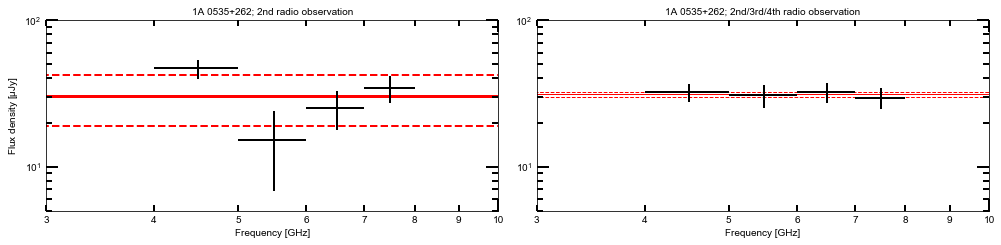

In [100]:
# Plotting the spectrum and the mean flux with uncertainty:
# All plotting commands are standard:
fig = plt.figure(figsize=(cm2inch(4.*single_col),cm2inch(1.*single_col)))
ax = fig.add_subplot(1,2,1)

ax.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=5)
    
ax.yaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both')

ax.set_xlabel('Frequency [GHz]', fontsize=FS)
ax.set_ylabel(r'Flux density [$\mu$Jy]', fontsize=FS)

ax.errorbar(nu, flux, xerr=dnu, yerr=dflux, fmt='ks', ms=0, elinewidth=2)

ax.set_ylim(5., 100)
ax.set_xlim(3, 10.)

ax.set_xscale('log')
ax.set_yscale('log')

# calculating the error on the flux as sigma/sqrt(N):
mu_err = np.std(flux, ddof=len(nu)-1)/(len(nu)**0.5)

ax.plot([0, 10], [np.mean(flux)+mu_err, np.mean(flux)+mu_err], 'r--', lw=2, zorder=0)
ax.plot([0, 10], [np.mean(flux)-mu_err, np.mean(flux)-mu_err], 'r--', lw=2, zorder=0)
ax.plot([0, 10], [np.mean(flux), np.mean(flux)], 'r-', lw=3, zorder=0)

ax.set_xticks([3,4,5,6,7,8,9], minor=True)
ax.set_xticklabels(['3','4','5','6','7','8','9'], minor=True)
ax.set_xticks([10], minor=False)
ax.set_xticklabels(['10'], minor=False)

ax.set_title('1A 0535+262; 2nd radio observation', fontsize=FS)

#################################################################################################################
ax = fig.add_subplot(1,2,2)

ax.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=5)
    
ax.yaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both')

ax.set_xlabel('Frequency [GHz]', fontsize=FS)
ax.set_yticklabels(['',''], minor=False)

ax.errorbar(nu_comb, flux_comb, xerr=dnu_comb, yerr=dflux_comb, fmt='ks', ms=0, elinewidth=2)

ax.set_ylim(5., 100)
ax.set_xlim(3, 10.)

ax.set_xscale('log')
ax.set_yscale('log')

# calculating the error on the flux as sigma/sqrt(N):
mu_err = np.std(flux_comb, ddof=len(nu)-1)/(len(nu)**0.5)

ax.plot([0, 10], [np.mean(flux_comb)+mu_err, np.mean(flux_comb)+mu_err], 'r--', lw=1, zorder=0)
ax.plot([0, 10], [np.mean(flux_comb)-mu_err, np.mean(flux_comb)-mu_err], 'r--', lw=1, zorder=0)
ax.plot([0, 10], [np.mean(flux_comb), np.mean(flux_comb)], 'r-', lw=1, zorder=0)

ax.set_xticks([3,4,5,6,7,8,9], minor=True)
ax.set_xticklabels(['3','4','5','6','7','8','9'], minor=True)
ax.set_xticks([10], minor=False)
ax.set_xticklabels(['10'], minor=False)

ax.set_title('1A 0535+262; 2nd/3rd/4th radio observation', fontsize=FS)

#################################################################################################################

plt.tight_layout()
plt.savefig('./OnlineSupplementaryMaterials/OSM_Figure1.png', dpi=500)

## Step 8: plotting the Swift and NICER parameter light curves for the Online Supplementary Materials

In [101]:
# Starting with Swift:
swift_0535 = np.genfromtxt('./OnlineSupplementaryMaterials/swift_machinereadable_0535.txt', unpack=True)

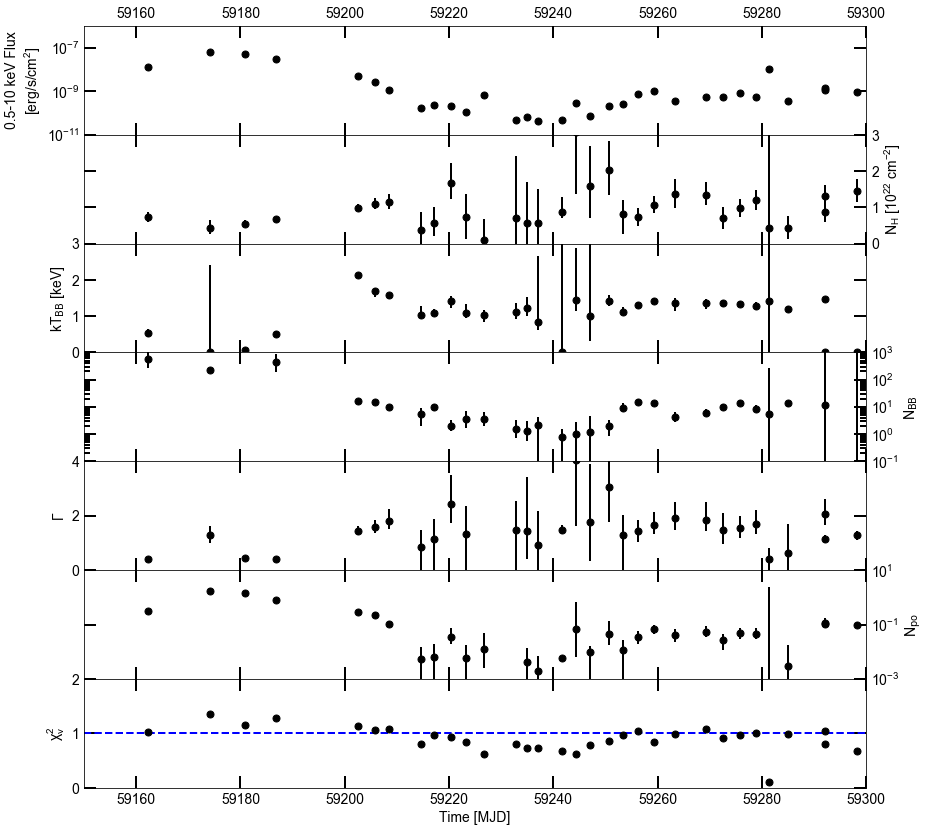

In [102]:
FS = 14
LS = 14
MS = 7
MEW= 1.5

FMT = 'ok'

# Setting up:
fig = plt.figure(figsize=(cm2inch(4.*single_col),cm2inch(4.*single_col)))

ax1 = fig.add_subplot(711)
ax2 = fig.add_subplot(712)
ax3 = fig.add_subplot(713)
ax4 = fig.add_subplot(714)
ax5 = fig.add_subplot(715)
ax6 = fig.add_subplot(716)
ax7 = fig.add_subplot(717)

ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')

ax_even = [ax2,ax4,ax6]
for ax in ax_even:
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    
AXES = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]
for ax in AXES:
    ax.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=5)
    ax.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=5)
    
    ax.yaxis.set_ticks_position('both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.xaxis.set_ticks_position('both')
    
    if ax != ax7 and ax != ax1:
        ax.set_xticklabels([])

    ax.set_xlim(59150, 59300.)
    
# Scales of the axes:
ax1.set_yscale('log')
ax1.set_ylim(1e-11, 1e-6)
ax2.set_ylim(0.,3.)
ax3.set_ylim(0.,3.)
ax4.set_ylim(0.1,1000)
ax4.set_yscale('log')
ax5.set_ylim(0.,4.)
ax6.set_ylim(1e-3,10)
ax6.set_yscale('log')
ax7.set_ylim(0.,2.)

# Labels of the axes:
ax7.set_xlabel('Time [MJD]', fontsize=FS)
ax1.set_ylabel(r'0.5-10 keV Flux'+'\n'+r'[erg/s/cm$^2$]', fontsize=FS)
ax2.set_ylabel(r'$N_H$ [$10^{22}$ cm$^{-2}$]', fontsize=FS)
ax3.set_ylabel(r'$kT_{\rm BB}$ [keV]', fontsize=FS)
ax4.set_ylabel(r'$N_{\rm BB}$', fontsize=FS)
ax5.set_ylabel(r'$\Gamma$', fontsize=FS)
ax6.set_ylabel(r'$N_{\rm po}$', fontsize=FS)
ax7.set_ylabel(r'$\chi^2_\nu$', fontsize=FS)

# Add a line for a reduced chi squared of 1:
ax7.plot([0, 1e10], [1,1], 'b--', lw=2)

# Remove the vertical space:
plt.subplots_adjust(wspace=0, hspace=0)

### Loading and plotting:
MJDs = swift_0535[3]
fluxes = swift_0535[6]
dfluxes = swift_0535[7]

# flux:
ax1.errorbar(MJDs, fluxes, yerr=dfluxes, fmt=FMT, ms=MS, elinewidth=2)   
# Nh:
ax2.errorbar(MJDs, swift_0535[8], yerr=[swift_0535[9],swift_0535[10]], fmt=FMT, ms=MS, elinewidth=2) 
# the parameters:
ax3.errorbar(MJDs, swift_0535[11], yerr=[swift_0535[12],swift_0535[13]], fmt=FMT, ms=MS, elinewidth=2) 
ax4.errorbar(MJDs, swift_0535[14], yerr=[swift_0535[15],swift_0535[16]], fmt=FMT, ms=MS, elinewidth=2) 
ax5.errorbar(MJDs, swift_0535[17], yerr=[swift_0535[18],swift_0535[19]], fmt=FMT, ms=MS, elinewidth=2) 
ax6.errorbar(MJDs, swift_0535[20], yerr=[swift_0535[21],swift_0535[22]], fmt=FMT, ms=MS, elinewidth=2) 
# rchi2:
ax7.plot(MJDs, swift_0535[23], FMT, ms=MS)

plt.savefig('./OnlineSupplementaryMaterials/OSM_Figure2.png', dpi=500)

# Resetting plotting input:
FS = 18
LS = 18
MS = 10
MEW= 1.5

In [103]:
# Continuing with NICER:
nicer_0535 = np.genfromtxt('./OnlineSupplementaryMaterials/nicer_machinereadable_0535.txt', unpack=True)

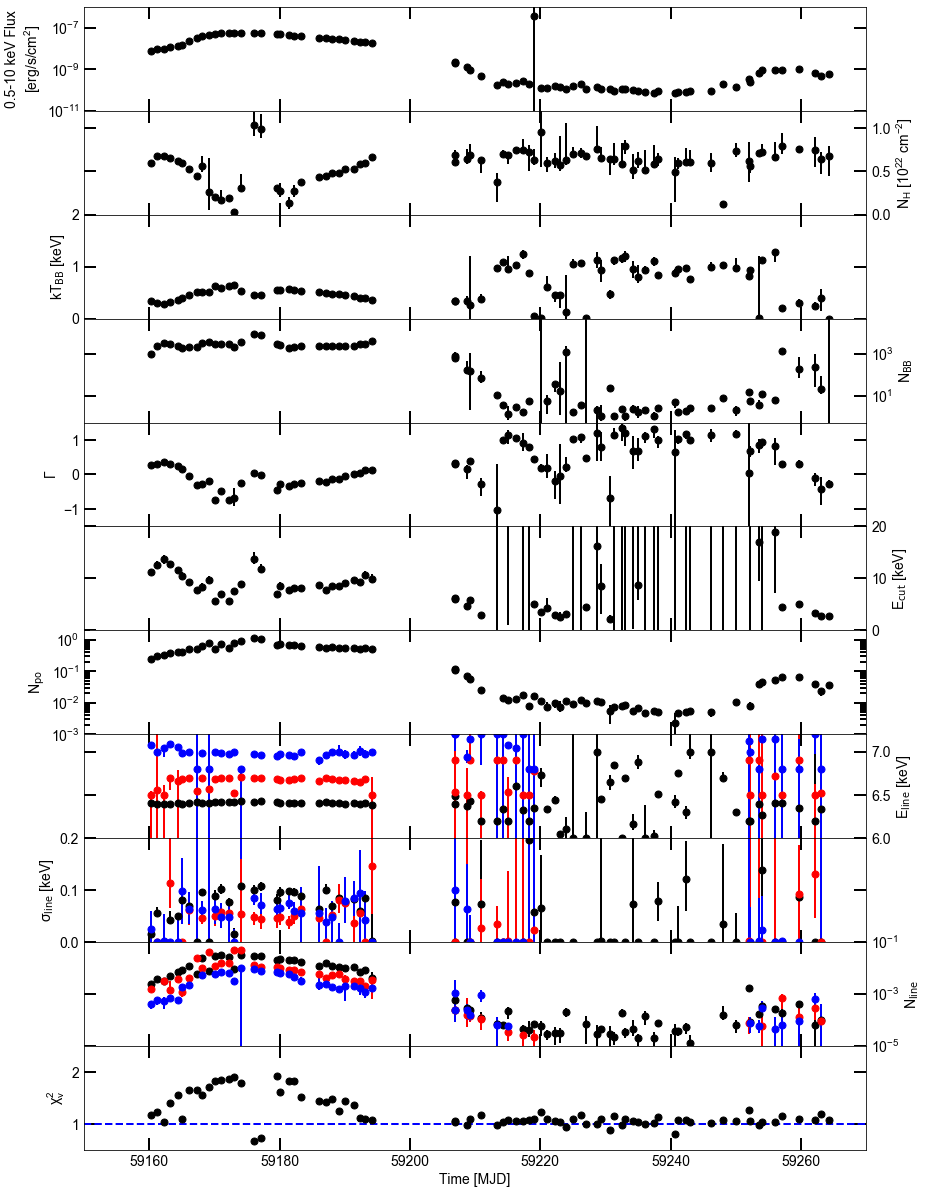

In [104]:
FS = 14
LS = 14
MS = 7
MEW= 1.5

FMT = 'ok'

# Setting up:
fig = plt.figure(figsize=(cm2inch(4.*single_col),cm2inch(6.*single_col)))

ax1 = fig.add_subplot(11,1,1)
ax2 = fig.add_subplot(11,1,2)
ax3 = fig.add_subplot(11,1,3)
ax4 = fig.add_subplot(11,1,4)
ax5 = fig.add_subplot(11,1,5)
ax6 = fig.add_subplot(11,1,6)
ax7 = fig.add_subplot(11,1,7)
ax8 = fig.add_subplot(11,1,8)
ax9 = fig.add_subplot(11,1,9)
ax10 = fig.add_subplot(11,1,10)
ax11 = fig.add_subplot(11,1,11)

ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')

ax_even = [ax2,ax4,ax6,ax8,ax10]
for ax in ax_even:
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    
AXES = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]
for ax in AXES:
    ax.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=5)
    ax.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=5)
    
    ax.yaxis.set_ticks_position('both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.xaxis.set_ticks_position('both')
    
    if ax != ax11 and ax != ax11:
        ax.set_xticklabels([])

    ax.set_xlim(59150, 59270.)
    
# Set all the scales for all the axes:
ax1.set_yscale('log')
ax1.set_ylim(1e-11, 1e-6)
ax2.set_ylim(0., 1.2)
ax3.set_ylim(0.,2.)
ax4.set_ylim(0.5,5e4)
ax4.set_yscale('log')
ax5.set_ylim(-1.5,1.5)
ax6.set_ylim(0,20)
ax7.set_ylim(1e-3,2.0)
ax7.set_yscale('log')
ax8.set_ylim(6,7.2)
ax9.set_ylim(0,0.2)
ax10.set_ylim(1e-5,1e-1)
ax10.set_yscale('log')
ax11.set_ylim(0.5,2.5)

# Set all the labels for all the axes:
ax11.set_xlabel('Time [MJD]', fontsize=FS)
ax1.set_ylabel(r'0.5-10 keV Flux'+'\n'+r'[erg/s/cm$^2$]', fontsize=FS)
ax2.set_ylabel(r'$N_H$ [$10^{22}$ cm$^{-2}$]', fontsize=FS)
ax3.set_ylabel(r'$kT_{\rm BB}$ [keV]', fontsize=FS)
ax4.set_ylabel(r'$N_{\rm BB}$', fontsize=FS)
ax5.set_ylabel(r'$\Gamma$', fontsize=FS)
ax6.set_ylabel(r'$E_{\rm cut}$ [keV]', fontsize=FS)
ax7.set_ylabel(r'$N_{\rm po}$', fontsize=FS)
ax8.set_ylabel(r'$E_{\rm line}$ [keV]', fontsize=FS)
ax9.set_ylabel(r'$\sigma_{\rm line}$ [keV]', fontsize=FS)
ax10.set_ylabel(r'$N_{\rm line}$', fontsize=FS)
ax11.set_ylabel(r'$\chi^2_\nu$', fontsize=FS)

# Add a line for a reduced chi squared of 1:
ax11.plot([0, 1e10], [1,1], 'b--', lw=2)

# Remove the vertical space:
plt.subplots_adjust(wspace=0, hspace=0)

### Loading and plotting:
MJDs = nicer_0535[3]
fluxes = nicer_0535[6]
dfluxes = nicer_0535[7]

# flux:
ax1.errorbar(MJDs, fluxes, yerr=dfluxes, fmt=FMT, ms=MS, elinewidth=2)   
# Nh:
ax2.errorbar(MJDs, nicer_0535[8], yerr=[nicer_0535[9],nicer_0535[10]], fmt=FMT, ms=MS, elinewidth=2) 
# the parameters:
ax3.errorbar(MJDs, nicer_0535[11], yerr=[nicer_0535[12],nicer_0535[13]], fmt=FMT, ms=MS, elinewidth=2) 
ax4.errorbar(MJDs, nicer_0535[14], yerr=[nicer_0535[15],nicer_0535[16]], fmt=FMT, ms=MS, elinewidth=2) 
ax5.errorbar(MJDs, nicer_0535[17], yerr=[nicer_0535[18],nicer_0535[19]], fmt=FMT, ms=MS, elinewidth=2) 
ax6.errorbar(MJDs, nicer_0535[20], yerr=[nicer_0535[21],nicer_0535[22]], fmt=FMT, ms=MS, elinewidth=2) 
ax7.errorbar(MJDs, nicer_0535[23], yerr=[nicer_0535[24],nicer_0535[25]], fmt=FMT, ms=MS, elinewidth=2) 
# the gaussian parameters:
ax8.errorbar(MJDs, nicer_0535[26], yerr=[nicer_0535[27],nicer_0535[28]], fmt=FMT, ms=MS, elinewidth=2) 
ax9.errorbar(MJDs, nicer_0535[29], yerr=[nicer_0535[30],nicer_0535[31]], fmt=FMT, ms=MS, elinewidth=2) 
ax10.errorbar(MJDs, nicer_0535[32], yerr=[nicer_0535[33],nicer_0535[34]], fmt=FMT, ms=MS, elinewidth=2) 
ax8.errorbar(MJDs, nicer_0535[35], yerr=[nicer_0535[36],nicer_0535[37]], fmt='or', ms=MS, elinewidth=2) 
ax9.errorbar(MJDs, nicer_0535[38], yerr=[nicer_0535[39],nicer_0535[40]], fmt='or', ms=MS, elinewidth=2) 
ax10.errorbar(MJDs, nicer_0535[41], yerr=[nicer_0535[42],nicer_0535[43]], fmt='or', ms=MS, elinewidth=2)
ax8.errorbar(MJDs, nicer_0535[44], yerr=[nicer_0535[45],nicer_0535[46]], fmt='ob', ms=MS, elinewidth=2) 
ax9.errorbar(MJDs, nicer_0535[47], yerr=[nicer_0535[48],nicer_0535[49]], fmt='ob', ms=MS, elinewidth=2) 
ax10.errorbar(MJDs, nicer_0535[50], yerr=[nicer_0535[51],nicer_0535[52]], fmt='ob', ms=MS, elinewidth=2)
# reduced chi squared:
ax11.plot(MJDs, nicer_0535[-2], FMT, ms=MS)

plt.savefig('./OnlineSupplementaryMaterials/OSM_Figure3.png', dpi=500)

# Resetting plotting input:
FS = 18
LS = 18
MS = 10
MEW= 1.5

## Step 9: plotting the NICER response comparison for the Online Supplementary Materials

In [105]:
# Read in the files:
o135_standard = np.genfromtxt('./OnlineSupplementaryMaterials/ld_135.qdp', unpack=True)
o135_specific = np.genfromtxt('./OnlineSupplementaryMaterials/ld_135_newbkgrsp.qdp', unpack=True)

# Calculate the radio and errors via error propegation:
ratio = o135_standard[2]/o135_specific[2]
dratio = ratio * ((o135_standard[3]/o135_standard[2] + o135_specific[3]/o135_specific[2])**0.5)

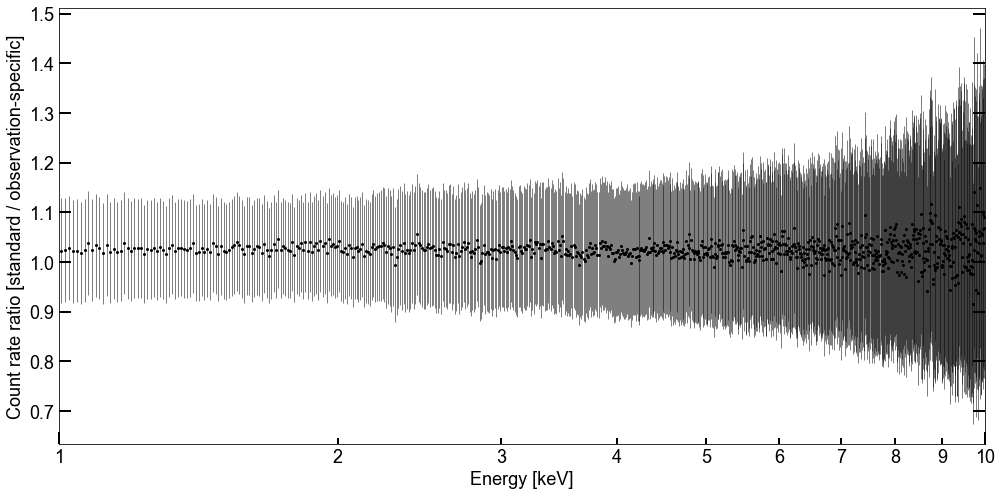

In [106]:
fig = plt.figure(figsize=(cm2inch(4.*single_col),cm2inch(2.*single_col)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=12, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=6, width=2, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
    
ax.set_xscale('log')
ax.set_xlim(1, 10)
    
ax.set_xlabel('Energy [keV]', fontsize=FS)
ax.set_ylabel('Count rate ratio [standard / observation-specific]', fontsize=FS)

ax.set_xticks([2,3,4,5,6,7,8,9], minor=True)
ax.set_xticks([1,10], minor=False)
ax.set_xticklabels(['2','3','4','5','6','7','8','9'], minor=True)
ax.set_xticklabels(['1','10'], minor=False)

ax.errorbar(o135_standard[0], ratio, yerr=dratio, fmt='ko', elinewidth=0.5, ms=2)

plt.tight_layout()
plt.savefig('./OnlineSupplementaryMaterials/OSM_Figure4.png', dpi=500)

# End of notebook